## Projet 4 : Construisez un modèle de scoring

## Contexte

Une société financière, nommée "Prêt à dépenser",  qui propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt souhaite mettre en œuvre un outil de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : crédit accordé ou refusé.

Elle souhaite donc développer un algorithme de classification pour aider à décider si un prêt peut être accordé à un client.

Les chargés de relation client seront les utilisateurs de l’outil de scoring. Puisqu’ils s’adressent aux clients, ils ont besoin qule e modèle soit facilement interprétable. Les chargés de relation souhaitent, en plus, disposer d’une mesure de l’importance des variables qui ont poussé le modèle à donner cette probabilité à un clienée

Notre objectif développer cet algorithme de classificationns.

## Librairies utilisées avec le langage Python:

In [4]:
!pip install scikeras
!pip install -U imbalanced-learn scikit-learn
!pip install xgboost
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 835.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 24.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 1.8 MB/s eta 0:00:00
   ━

In [1]:
# Importation des librairies
import numpy as np
from numpy import where
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC # svC car problème de classification (sinon SVR pour la regression)
from sklearn.model_selection import  GridSearchCV, cross_validate, cross_val_score, cross_val_predict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn import  metrics
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,fbeta_score,roc_auc_score,confusion_matrix,precision_recall_curve,average_precision_score
from sklearn.metrics import PrecisionRecallDisplay, make_scorer
import tensorflow as tf; tf.keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.activations import sigmoid
from scikeras.wrappers import KerasClassifier
# from keras.callbacks import Callback
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap
import time
import os

import warnings
warnings.filterwarnings('ignore')

shap.initjs()

## Données brutes:

Nous avons 4 fichiers CSV :
- X_train : dataframe d'entrainement
- X_test : dataframe de test
- y_train : array de la variable cible pour le dataframe d'entrainement
- y_test : array de la variable cible pour le dataframe de test


In [2]:
y_train = pd.read_csv('/content/drive/MyDrive/data/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/data/y_test.csv')
X_train = pd.read_csv('/content/drive/MyDrive/data/X_train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/data/X_test.csv')


## Normalisation et équilibrage des données:

Afin que les différents ordres de grandeur des variables n'impactent pas les résultats des modèles, normalisons les données pour que chaque variable ait une moyenne égale à 0 et une variance égale à 1.

In [3]:
# Créer une instance de Standardscaler
scaler = StandardScaler()

# Normalisation des données (entrainement de l'imputer seulement sur les données d'entrainement pour éviter la fuite de données)
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test_norm = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

# Save the processed data
X_train_norm.to_csv('/content/X_train_norm.csv', index=False)
X_test_norm.to_csv('/content/X_test_norm.csv', index=False)

X_train_norm.describe(include="all")

NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
count        2.460080e+05  2.460080e+05     2.460080e+05  2.460080e+05   
mean        -1.740195e-17 -2.566247e-17    -1.001587e-16  6.598301e-17   
std          1.000002e+00  1.000002e+00     1.000002e+00  1.000002e+00   
min         -3.247234e-01 -7.181585e-01    -1.504877e+00 -5.788480e-01   
25%         -3.247234e-01 -7.181585e-01    -1.504877e+00 -5.788480e-01   
50%         -3.247234e-01 -7.181585e-01     6.645063e-01 -5.788480e-01   
75%         -3.247234e-01  1.392450e+00     6.645063e-01  8.093218e-01   
max          3.079544e+00  1.392450e+00     6.645063e-01  2.579638e+01   

       AMT_INCOME_TOTAL    AMT_CREDIT   AMT_ANNUITY  AMT_GOODS_PRICE  \
count      2.460080e+05  2.460080e+05  2.460080e+05     2.460080e+05   
mean       3.396630e-17 -1.191998e-16  1.198930e-16     1.344139e-16   
std        1.000002e+00  1.000002e+00  1.000002e+00     1.000002e+00   
min       -5.533760e-01 -1.374886e+00 -1.755635e+00    -1.334438e+00   
25%       -2.177083e-01 -8.160175e-01 -7.296359e-01    -8.105069e-01   
50%       -8.726755e-02 -2.124392e-01 -1.513679e-01    -2.378382e-01   
75%        1.301338e-01  5.219143e-01  5.168184e-01     3.835683e-01   
max        4.515422e+02  8.572978e+00  1.399186e+01     9.509714e+00   

       REGION_POPULATION_RELATIVE  DAYS_EMPLOYED  ...  \
count                2.460080e+05   2.460080e+05  ...   
mean                -1.502561e-16  -7.081187e-17  ...   
std                  1.000002e+00   1.000002e+00  ...   
min                 -1.488335e+00  -7.174946e+00  ...   
25%                 -7.856671e-01  -2.393255e-01  ...   
50%                 -1.460626e-01   2.833847e-01  ...   
75%                  5.636207e-01   6.184433e-01  ...   
max                  3.734523e+00   1.053177e+00  ...   

       EXT_SOURCE_2 EXT_SOURCE_3 AGE  EXT_SOURCE_2 AGE^2  EXT_SOURCE_3^3  \
count                   2.460080e+05        2.460080e+05    2.460080e+05   
mean                    2.041155e-16       -3.093938e-16   -1.830166e-16   
std                     1.000002e+00        1.000002e+00    1.000002e+00   
min                    -1.583469e+00       -1.498425e+00   -1.285525e+00   
25%                    -7.856490e-01       -7.913814e-01   -7.778655e-01   
50%                    -1.347512e-01       -2.144636e-01   -1.989178e-01   
75%                     6.481073e-01        6.342508e-01    5.403890e-01   
max                     4.465937e+00        3.695439e+00    3.811027e+00   

       EXT_SOURCE_3^2 AGE  EXT_SOURCE_3 AGE^2         AGE^3  \
count        2.460080e+05        2.460080e+05  2.460080e+05   
mean         4.607908e-17       -5.362040e-16 -2.288249e-16   
std          1.000002e+00        1.000002e+00  1.000002e+00   
min         -1.474042e+00       -1.490044e+00 -1.236052e+00   
25%         -7.364646e-01       -7.992879e-01 -8.379680e-01   
50%         -1.525855e-01       -2.310782e-01 -3.044047e-01   
75%          5.418466e-01        6.217268e-01  6.868723e-01   
max          4.266265e+00        3.987615e+00  2.938628e+00   

       CREDIT_INCOME_PERCENT  ANNUITY_INCOME_PERCENT   CREDIT_TERM  \
count           2.460080e+05            2.460080e+05  2.460080e+05   
mean           -2.544585e-17            2.618236e-17  4.396846e-16   
std             1.000002e+00            1.000002e+00  1.000002e+00   
min            -1.469247e+00           -1.910678e+00 -1.407703e+00   
25%            -7.211528e-01           -7.006335e-01 -7.465883e-01   
50%            -2.591908e-01           -1.918845e-01 -1.652879e-01   
75%             4.461135e-01            5.076919e-01  4.598731e-01   
max             3.005412e+01            1.793057e+01  3.145881e+00   

       DAYS_EMPLOYED_PERCENT  
count           2.460080e+05  
mean            8.224409e-17  
std             1.000002e+00  
min            -1.229568e+00  
25%            -6.704507e-01  
50%            -2.576931e-01  
75%             3.388940e-01  
max             4.697029e+00  

[8 rows x 276

In [4]:
rus = RandomUnderSampler(
        sampling_strategy=1.0,  # perfect balance
        random_state=42,
    )

X_train_eq, y_train_eq = rus.fit_resample(X_train_norm, y_train)

# Save the processed data
X_train_eq.to_csv('/content/X_train_eq.csv', index=False)
y_train_eq.to_csv('/content/y_train_eq.csv', index=False)


Nouséquilibrerons nos données directement dans les pipelines avec les classifieurs pour éviter toute fuite de données.

## Modélisation et évaluation:

Nous allons tester différents modèles de classification binaire et évaluer leur efficacité en terme de performances et de temps d'entainement et d'exécution.

Pour l'évaluation des performances nous allons calculer différentes métriques :
- l'accuracy (efficacité d'un modèle à prédire correctement à la fois les individus positifs et négatifs)
- la précision (nombre de positifs bien prédit (Vrai Positif) divisé par l’ensemble des positifs prédit)
- le recall (nombre de positifs bien prédit (VP) divisé par l’ensemble des positifs)
- le F1 score (moyenne harmonique du recall et de la precision)
- le F beta score (avec beta>1, pour accorder plus d’importance au recall (autrement dit aux Faux Négatif) puisque la prédiction des difficultés de remboursement est plus importante pour l'entreprise. En effet, les FN coûtent plus d'argent que les Faux Positifs.)
- l'aire sous la courbe ROC (relation entre spécificité et sensibilité)
- l'aire sous la courbe PR (relation entre précision et recall)


Nous ajouterons un score "métier" qui correspondra au coût des erreurs de prédiction et que nous devrons minimiser.


In [5]:
# Création de la fonction de coût personnalisée pour laquelle les FN coutent 10 fois plus que les FP
def cout_score (y,y_pred) :
  tn,fp,fn,tp = confusion_matrix(y,y_pred).ravel()
  cout_total = fn*10 + fp*1
  return cout_total


### Modèle de base :
Notre modèle de base va effectuer des prédictions basées sur la valeur de la variable la plus fréquente.

In [ ]:
pipeline_dummy=imbpipeline(steps=[
    ['classifier',DummyClassifier(strategy=  "most_frequent",random_state=42)]
])

#Entrainement du classifieur
clf=pipeline_dummy.fit(X_train_eq,y_train_eq)

#Prédiction de la variable cible sur la base de données test
y_pred = clf.predict(X_test_norm)
y_pred_proba = clf.predict_proba(X_test_norm)[:, 1]

#Distribution de la variable cible sur la base de données test
print('y réel : \n' +  str(y_test.value_counts())+'\n')

#Distribution de la variable cible prédite
print('y prédit: \n' + str(pd.Series(y_pred).value_counts()))

y réel : 
TARGET_x
0           56562
1            4941
Name: count, dtype: int64

y prédit: 
0    61503
Name: count, dtype: int64


In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred))) #si problème de régression, remplacé par R²
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))
print('F beta Score (avec beta=2) : ' + str(fbeta_score(y_test,y_pred, beta=2)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_pred)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_pred_proba)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_pred)))

Accuracy Score : 0.919662455489976
Precision Score : 0.0
Recall Score : 0.0
F1 Score : 0.0
F beta Score (avec beta=2) : 0.0
Aire sous la courbe ROC : 0.5
Aire sous la courbe PR : 0.0803375445100239
Score de couts des erreurs de prédiction : 49410


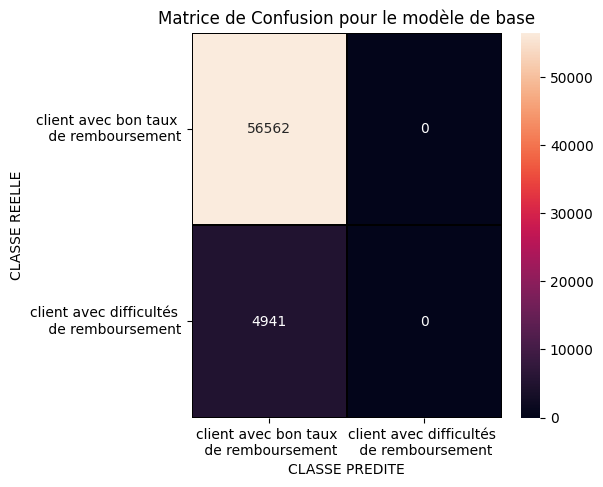

In [ ]:
# Graphique de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le modèle de base')
plt.show()

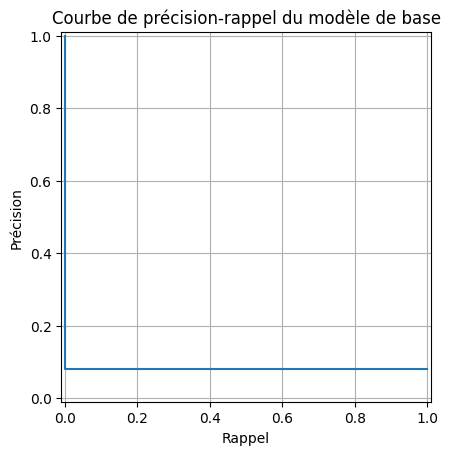

In [ ]:
# Graphique précision-rappel
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel du modèle de base')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC du modèle de base')

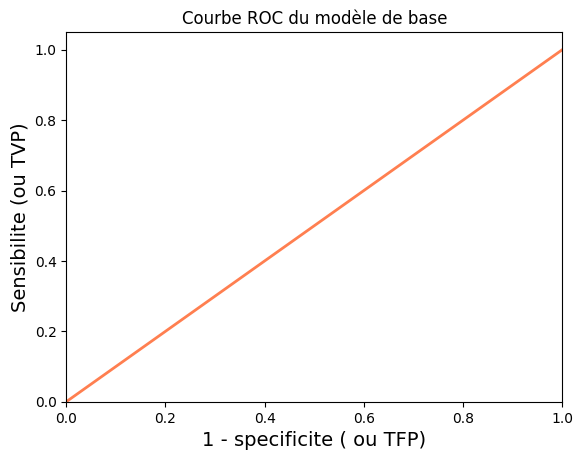

In [ ]:
# Graphique courbe ROC
[fpr, tpr, thr] = metrics.roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC du modèle de base')

Nous voyons que prédire la classe la plus représentée (ici 0) permet d'obtenir une bonne accuracy mais des résultats médiocres pour tous les autres scores.

De plus, il n'y a aucune minimisation des FN puisque toutes les prédictions sont égales à 0 donc avec un bon taux de remboursement. Or c'est ce que l'on souhaite obtenir !

### Modèles linéaires de régression logistique :

Le modèle de régression logistique est un modèle simple qui analyse les relations entre une variable cible binaire et l’ensemble des autres variables indépendantes. Cette relation est exprimée comme une équation qui prédit la probabilité de réalisation des deux classes de la variable cible comme une combinaison linéaire de paramètres suivant une fonction logistique.


In [ ]:
pipeline_lr=imbpipeline(steps=[
    ['classifier', LogisticRegression(solver="liblinear",random_state=42)]
])

params_lr = {'classifier__penalty' : ['l1','l2'],'classifier__C': [0.001,0.01,0.1,1,10,100]}
scorer = {'main': 'accuracy', 'f1' : 'f1','custom': make_scorer(cout_score, greater_is_better=False)}

# optimisation des paramètres avec la grid search en fonction de notre score "métier"
grid_lr = GridSearchCV(pipeline_lr, params_lr,scoring=scorer,refit='custom', cv=3, n_jobs=None)
grid_lr.fit(X_train_eq,y_train_eq)

#récupération des meilleurs hyperparamètres
best_model_lr_gs = grid_lr.best_estimator_

In [ ]:
print(best_model_lr_gs)

Pipeline(steps=[['classifier',
                 LogisticRegression(C=0.001, penalty='l1', random_state=42,
                                    solver='liblinear')]])


In [ ]:
cvres_lr=pd.DataFrame(grid_lr.cv_results_)
cvres_lr

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.157726      0.043203         0.080386        0.024004   
1        1.948487      0.283208         0.074071        0.021663   
2        2.074190      0.590611         0.052219        0.000665   
3        3.376662      0.438152         0.108083        0.002814   
4       14.303525     10.286120         0.052649        0.002073   
5        7.773555      0.212608         0.072671        0.023235   
6      110.280327      3.345371         0.081632        0.023732   
7       20.025048      1.443196         0.077135        0.024124   
8      239.985917     33.247159         0.072388        0.011090   
9       36.265455      1.858226         0.070720        0.024604   
10     238.211669     15.483977         0.076242        0.009747   
11      43.908367      2.073933         0.086013        0.023948   

    param_classifier__C param_classifier__penalty  \
0                 0.001                        l1   
1                 0.001                        l2   
2                 0.010                        l1   
3                 0.010                        l2   
4                 0.100                        l1   
5                 0.100                        l2   
6                 1.000                        l1   
7                 1.000                        l2   
8                10.000                        l1   
9                10.000                        l2   
10              100.000                        l1   
11              100.000                        l2   

                                               params  split0_test_main  \
0   {'classifier__C': 0.001, 'classifier__penalty'...          0.650045   
1   {'classifier__C': 0.001, 'classifier__penalty'...          0.678033   
2   {'classifier__C': 0.01, 'classifier__penalty':...          0.678862   
3   {'classifier__C': 0.01, 'classifier__penalty':...          0.680597   
4   {'classifier__C': 0.1, 'classifier__penalty': ...          0.681729   
5   {'classifier__C': 0.1, 'classifier__penalty': ...          0.681050   
6   {'classifier__C': 1, 'classifier__penalty': 'l1'}          0.682559   
7   {'classifier__C': 1, 'classifier__penalty': 'l2'}          0.682861   
8   {'classifier__C': 10, 'classifier__penalty': '...          0.682634   
9   {'classifier__C': 10, 'classifier__penalty': '...          0.683238   
10  {'classifier__C': 100, 'classifier__penalty': ...          0.682559   
11  {'classifier__C': 100, 'classifier__penalty': ...          0.682861   

    split1_test_main  split2_test_main  ...  split2_test_f1  mean_test_f1  \
0           0.651705          0.647103  ...        0.682417      0.685289   
1           0.684747          0.677429  ...        0.689154      0.690544   
2           0.685878          0.678485  ...        0.682556      0.684218   
3           0.685048          0.676222  ...        0.678309      0.681329   
4           0.687538          0.678787  ...        0.679223      0.682301   
5           0.687010          0.678259  ...        0.678186      0.680733   
6           0.688669          0.680371  ...        0.680540      0.682308   
7           0.688594          0.680145  ...        0.680193      0.682277   
8           0.687839          0.680371  ...        0.680009      0.681878   
9           0.687990          0.680824  ...        0.680317      0.682186   
10          0.688066          0.680447  ...        0.679964      0.681818   
11          0.687764          0.681276  ...        0.680578      0.681974   

    std_test_f1  rank_test_f1  split0_test_custom  split1_test_custom  \
0      0.002176             2            -18733.0            -18522.0   
1      0.001906             1            -21323.0            -21333.0   
2      0.002576             3            -22779.0            -22524.0   
3      0.002431            11            -23134.0            -23111.0   
4      0.002788             5            -23209.0            -23078.0   
5      0.0027

"mean_test_score" et "mean_train_score" renvoient des valeurs négatives car nous utilisons une fonction de coût que l'on cherche à minimiser. Cependant, dans la fonction GridSearchCV, le choix du meilleur modèle correspond toujours à la valeur du "mean_test_score" maximum, c'est pourquoi ils transforment les valeur positives en valeurs négatives dans ce cas.

In [ ]:
cols= [i for i in cvres_lr.columns if "split" not in i ]
cvres_lr=cvres_lr [cols].sort_values("rank_test_main")
cvres_lr.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
9       36.265455      1.858226         0.070720        0.024604   
11      43.908367      2.073933         0.086013        0.023948   
6      110.280327      3.345371         0.081632        0.023732   
7       20.025048      1.443196         0.077135        0.024124   
10     238.211669     15.483977         0.076242        0.009747   
8      239.985917     33.247159         0.072388        0.011090   
4       14.303525     10.286120         0.052649        0.002073   
5        7.773555      0.212608         0.072671        0.023235   
2        2.074190      0.590611         0.052219        0.000665   
3        3.376662      0.438152         0.108083        0.002814   

    param_classifier__C param_classifier__penalty  \
9                 10.00                        l2   
11               100.00                        l2   
6                  1.00                        l1   
7                  1.00                        l2   
10               100.00                        l1   
8                 10.00                        l1   
4                  0.10                        l1   
5                  0.10                        l2   
2                  0.01                        l1   
3                  0.01                        l2   

                                               params  mean_test_main  \
9   {'classifier__C': 10, 'classifier__penalty': '...        0.684017   
11  {'classifier__C': 100, 'classifier__penalty': ...        0.683967   
6   {'classifier__C': 1, 'classifier__penalty': 'l1'}        0.683866   
7   {'classifier__C': 1, 'classifier__penalty': 'l2'}        0.683866   
10  {'classifier__C': 100, 'classifier__penalty': ...        0.683690   
8   {'classifier__C': 10, 'classifier__penalty': '...        0.683615   
4   {'classifier__C': 0.1, 'classifier__penalty': ...        0.682685   
5   {'classifier__C': 0.1, 'classifier__penalty': ...        0.682106   
2   {'classifier__C': 0.01, 'classifier__penalty':...        0.681075   
3   {'classifier__C': 0.01, 'classifier__penalty':...        0.680623   

    std_test_main  rank_test_main  mean_test_f1  std_test_f1  rank_test_f1  \
9        0.002977               1      0.682186     0.001771             7   
11       0.002762               2      0.681974     0.001451             8   
6        0.003512               3      0.682308     0.002504             4   
7        0.003522               3      0.682277     0.002379             6   
10       0.003212               5      0.681818     0.002043            10   
8        0.003127               6      0.681878     0.002000             9   
4        0.003636               7      0.682301     0.002788             5   
5        0.003650               8      0.680733     0.002784            12   
2        0.003400               9      0.684218     0.002576             3   
3        0.003603              10      0.681329     0.002431            11   

    mean_test_custom  std_test_custom  rank_test_custom  
9      -23382.666667        13.021350                 8  
11     -23416.333333        46.991725                11  
6      -23342.666667       127.753234                 6  
7      -23348.666667        83.171844                 7  
10     -23414.000000        38.192495                10  
8      -23394.000000        39.064050                 9  
4      -23208.333333       106.145602                 5  
5      -23435.000000       119.501743                12  
2      -22659.666667       104.742011                 3  
3      -23154.666667        46.449495                 4

In [ ]:
cvres_lr=cvres_lr [cols].sort_values("rank_test_f1")
cvres_lr.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1        1.948487      0.283208         0.074071        0.021663   
0        1.157726      0.043203         0.080386        0.024004   
2        2.074190      0.590611         0.052219        0.000665   
6      110.280327      3.345371         0.081632        0.023732   
4       14.303525     10.286120         0.052649        0.002073   
7       20.025048      1.443196         0.077135        0.024124   
9       36.265455      1.858226         0.070720        0.024604   
11      43.908367      2.073933         0.086013        0.023948   
8      239.985917     33.247159         0.072388        0.011090   
10     238.211669     15.483977         0.076242        0.009747   

    param_classifier__C param_classifier__penalty  \
1                 0.001                        l2   
0                 0.001                        l1   
2                 0.010                        l1   
6                 1.000                        l1   
4                 0.100                        l1   
7                 1.000                        l2   
9                10.000                        l2   
11              100.000                        l2   
8                10.000                        l1   
10              100.000                        l1   

                                               params  mean_test_main  \
1   {'classifier__C': 0.001, 'classifier__penalty'...        0.680069   
0   {'classifier__C': 0.001, 'classifier__penalty'...        0.649618   
2   {'classifier__C': 0.01, 'classifier__penalty':...        0.681075   
6   {'classifier__C': 1, 'classifier__penalty': 'l1'}        0.683866   
4   {'classifier__C': 0.1, 'classifier__penalty': ...        0.682685   
7   {'classifier__C': 1, 'classifier__penalty': 'l2'}        0.683866   
9   {'classifier__C': 10, 'classifier__penalty': '...        0.684017   
11  {'classifier__C': 100, 'classifier__penalty': ...        0.683967   
8   {'classifier__C': 10, 'classifier__penalty': '...        0.683615   
10  {'classifier__C': 100, 'classifier__penalty': ...        0.683690   

    std_test_main  rank_test_main  mean_test_f1  std_test_f1  rank_test_f1  \
1        0.003316              11      0.690544     0.001906             1   
0        0.001903              12      0.685289     0.002176             2   
2        0.003400               9      0.684218     0.002576             3   
6        0.003512               3      0.682308     0.002504             4   
4        0.003636               7      0.682301     0.002788             5   
7        0.003522               3      0.682277     0.002379             6   
9        0.002977               1      0.682186     0.001771             7   
11       0.002762               2      0.681974     0.001451             8   
8        0.003127               6      0.681878     0.002000             9   
10       0.003212               5      0.681818     0.002043            10   

    mean_test_custom  std_test_custom  rank_test_custom  
1      -21308.000000        28.577380                 2  
0      -18783.666667       237.057424                 1  
2      -22659.666667       104.742011                 3  
6      -23342.666667       127.753234                 6  
4      -23208.333333       106.145602                 5  
7      -23348.666667        83.171844                 7  
9      -23382.666667        13.021350                 8  
11     -23416.333333        46.991725                11  
8      -23394.000000        39.064050                 9  
10     -23414.000000        38.192495                10

In [ ]:
cvres_lr=cvres_lr [cols].sort_values("rank_test_custom")
cvres_lr.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.157726      0.043203         0.080386        0.024004   
1        1.948487      0.283208         0.074071        0.021663   
2        2.074190      0.590611         0.052219        0.000665   
3        3.376662      0.438152         0.108083        0.002814   
4       14.303525     10.286120         0.052649        0.002073   
6      110.280327      3.345371         0.081632        0.023732   
7       20.025048      1.443196         0.077135        0.024124   
9       36.265455      1.858226         0.070720        0.024604   
8      239.985917     33.247159         0.072388        0.011090   
10     238.211669     15.483977         0.076242        0.009747   

    param_classifier__C param_classifier__penalty  \
0                 0.001                        l1   
1                 0.001                        l2   
2                 0.010                        l1   
3                 0.010                        l2   
4                 0.100                        l1   
6                 1.000                        l1   
7                 1.000                        l2   
9                10.000                        l2   
8                10.000                        l1   
10              100.000                        l1   

                                               params  mean_test_main  \
0   {'classifier__C': 0.001, 'classifier__penalty'...        0.649618   
1   {'classifier__C': 0.001, 'classifier__penalty'...        0.680069   
2   {'classifier__C': 0.01, 'classifier__penalty':...        0.681075   
3   {'classifier__C': 0.01, 'classifier__penalty':...        0.680623   
4   {'classifier__C': 0.1, 'classifier__penalty': ...        0.682685   
6   {'classifier__C': 1, 'classifier__penalty': 'l1'}        0.683866   
7   {'classifier__C': 1, 'classifier__penalty': 'l2'}        0.683866   
9   {'classifier__C': 10, 'classifier__penalty': '...        0.684017   
8   {'classifier__C': 10, 'classifier__penalty': '...        0.683615   
10  {'classifier__C': 100, 'classifier__penalty': ...        0.683690   

    std_test_main  rank_test_main  mean_test_f1  std_test_f1  rank_test_f1  \
0        0.001903              12      0.685289     0.002176             2   
1        0.003316              11      0.690544     0.001906             1   
2        0.003400               9      0.684218     0.002576             3   
3        0.003603              10      0.681329     0.002431            11   
4        0.003636               7      0.682301     0.002788             5   
6        0.003512               3      0.682308     0.002504             4   
7        0.003522               3      0.682277     0.002379             6   
9        0.002977               1      0.682186     0.001771             7   
8        0.003127               6      0.681878     0.002000             9   
10       0.003212               5      0.681818     0.002043            10   

    mean_test_custom  std_test_custom  rank_test_custom  
0      -18783.666667       237.057424                 1  
1      -21308.000000        28.577380                 2  
2      -22659.666667       104.742011                 3  
3      -23154.666667        46.449495                 4  
4      -23208.333333       106.145602                 5  
6      -23342.666667       127.753234                 6  
7      -23348.666667        83.171844                 7  
9      -23382.666667        13.021350                 8  
8      -23394.000000        39.064050                 9  
10     -23414.000000        38.192495                10

Les hyperparamètres optimisés correspondent au couple {'C': 0.001, 'penalty': l1	} et entrainent une maximisation  du mean_test_custom (= -1*cout_score) égal à 18783.66 avec un minimum de temps d'entrainement et de prédiction.


Evaluons ces hyper-paramètres sur le jeu de test :

In [ ]:
# best_model_lr_gs=LogisticRegression(solver="liblinear",penalty="l2",C=100,random_state=42)
best_model_lr_gs.fit(X_train_eq,y_train_eq)

Pipeline(steps=[['classifier',
                 LogisticRegression(C=0.001, penalty='l1', random_state=42,
                                    solver='liblinear')]])

(array([  229.,  1813.,  5265.,  8484., 10603., 10098.,  9400.,  8285.,
         5605.,  1721.]),
 array([0.06511233, 0.13997946, 0.2148466 , 0.28971373, 0.36458087,
        0.43944801, 0.51431514, 0.58918228, 0.66404941, 0.73891655,
        0.81378369]),
 <BarContainer object of 10 artists>)

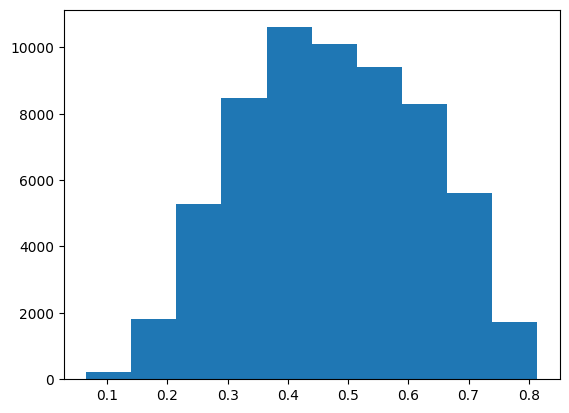

In [ ]:
y_proba_lr=best_model_lr_gs.predict_proba(X_test_norm)[:, 1]
y_pred_lr=best_model_lr_gs.predict(X_test_norm)
plt.hist(y_proba_lr)

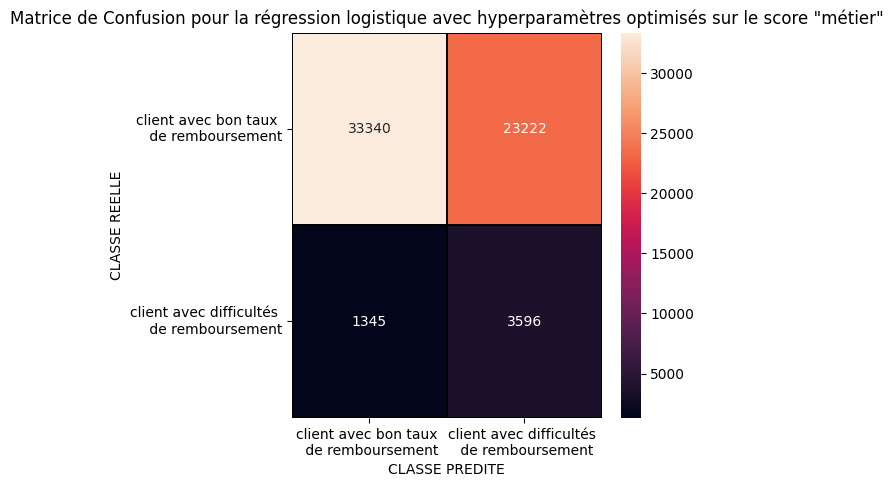

In [ ]:
# Graphique de la matrice de confusion
cm_lr = confusion_matrix(y_test, y_pred_lr)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_lr, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la régression logistique avec hyperparamètres optimisés sur le score "métier"')
plt.show()

In [ ]:
# score de la régression logistique avec hyper-paramètresn optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred_lr)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_lr)))
print('Recall Score : ' + str(recall_score(y_test, y_pred_lr)))
print('F1 Score : ' + str(f1_score(y_test, y_pred_lr)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test, y_pred_lr, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test, y_proba_lr)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_proba_lr)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_pred_lr)))

Accuracy Score : 0.6005560704355886
Precision Score : 0.1340890446714893
Recall Score : 0.7277878971868043
F1 Score : 0.22645549293113762
F beta Score (avec beta=3) : 0.5044397996829717
Aire sous la courbe ROC : 0.7207946810087543
Aire sous la courbe PR : 0.2018007236421333
Score de couts des erreurs de prédiction : 36672


Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser notre score "métier" créé sur les données d'entrainement non équilibrées.

In [ ]:
# probabilité des prédictiond sur les données d'entrainement avec les meilleurs hyperparamètres pour optimiser le seuil de décision
y_proba_lr_train = best_model_lr_gs.predict_proba(X_train_norm)[:, 1]
y_pred_lr_train = best_model_lr_gs.predict(X_train_norm)


In [6]:
def threshold_selection_cout(y_proba, y_train):

    scores = []
    for threshold in np.linspace(0, 1, num=100):
        y_pred = y_proba > threshold
        score = cout_score(y_train, y_pred)
        scores.append(score)

    scores = np.asarray(scores)
    best_threshold, best_score = (scores.argmin()*.01, round(scores.min(),3))

    print('Best Threshold :', best_threshold)
    print('Best Score :', best_score)

    plt.plot(np.linspace(0, 1, num=100), scores, lw=1)
    plt.axvline(best_threshold, ls='--', lw=1, c='r')
    plt.xlabel('Threshold')
    plt.ylabel('Score performed')
    plt.show()

Best Threshold : 0.55
Best Score : 141103


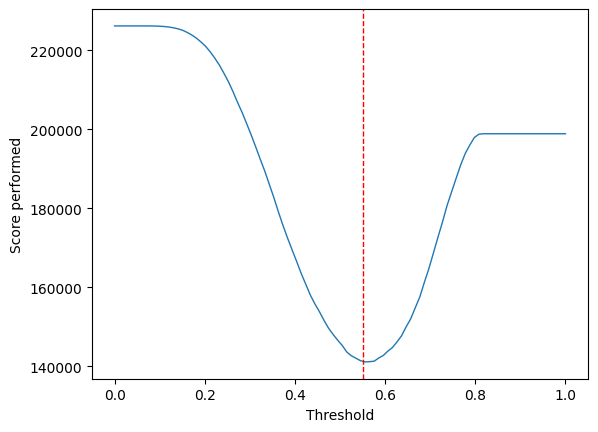

In [ ]:
threshold_selection_cout(y_proba_lr_train,y_train)

Evaluons ces hyper-paramètres ainsi que ce seuil optimisé sur les données de test :

In [ ]:
# prédiction sur les données de test avec les meilleurs hyperparamètres et le seuil optimisé avec le score "métier"
y_lr_opt_test = (best_model_lr_gs.predict_proba(X_test_norm)[:,1] >= 0.55).astype(int)
y_lr_opt_proba_test = best_model_lr_gs.predict_proba(X_test_norm)[:, 1]

In [ ]:
# score de la régression logistique avec hyperparamètres et seuil optimisés avec le score "métier"
print('Accuracy Score : ' + str(accuracy_score(y_test,y_lr_opt_test)))
print('Precision Score : ' + str(precision_score(y_test,y_lr_opt_test)))
print('Recall Score : ' + str(recall_score(y_test,y_lr_opt_test)))
print('F1 Score : ' + str(f1_score(y_test,y_lr_opt_test)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_lr_opt_test, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_lr_opt_test)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_lr_opt_test)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_lr_opt_test)))

Accuracy Score : 0.6881778124644327
Precision Score : 0.1507286197929444
Recall Score : 0.6217364905889496
F1 Score : 0.24263486296501066
F beta Score (avec beta=3) : 0.47370855821125674
Aire sous la courbe ROC : 0.6578591579213268
Aire sous la courbe PR : 0.12410224462520944
Score de couts des erreurs de prédiction : 35999


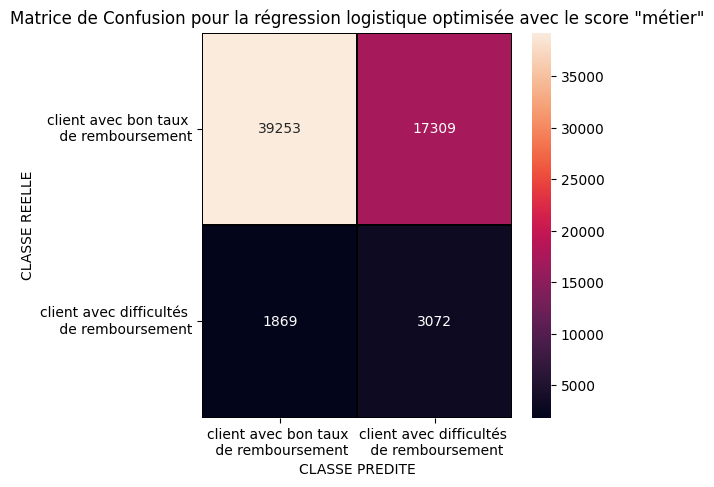

In [ ]:
# Graphique de la matrice de confusion
cm_lr = confusion_matrix(y_test, y_lr_opt_test)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_lr, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la régression logistique optimisée avec le score "métier"')
plt.show()

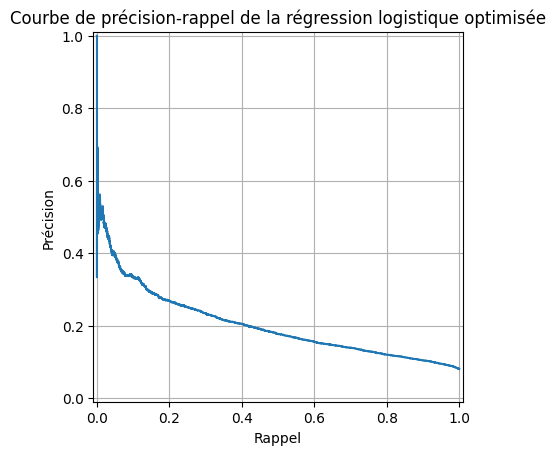

In [ ]:
# Graphique précision-rappel
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_lr_opt_proba_test)
disp_lr = PrecisionRecallDisplay(precision=precision_lr, recall=recall_lr)
disp_lr.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la régression logistique optimisée')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la régression logistique optimisée')

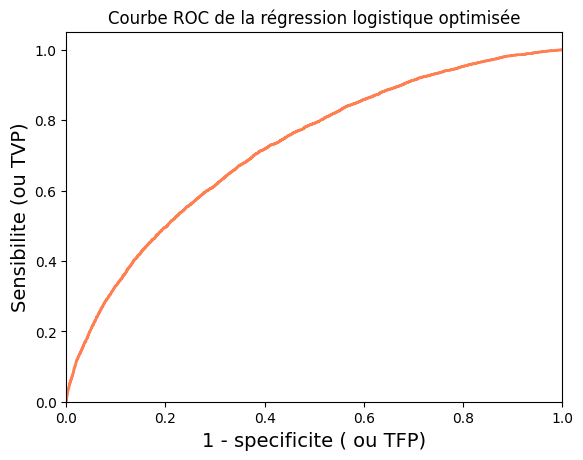

In [ ]:
# Graphique courbe ROC
[fpr_lr, tpr_lr, thr_lr] = metrics.roc_curve(y_test, y_lr_opt_proba_test)
plt.plot(fpr_lr, tpr_lr, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la régression logistique optimisée')

Text(0.5, 0, "Top 20 des variables avec le plus d'importance")

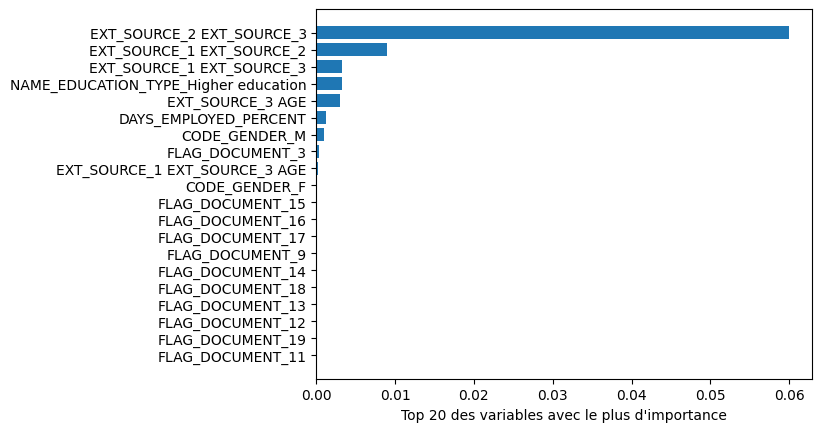

In [ ]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
perm_importance = permutation_importance(best_model_lr_gs, X_train_eq,y_train_eq)

feature_names = X_train_eq.columns
features = np.array(feature_names)

sorted_idx = abs(perm_importance.importances_mean).argsort()
plt.barh(features[sorted_idx[-20:]], perm_importance.importances_mean[sorted_idx[-20:]])
plt.xlabel("Top 20 des variables avec le plus d'importance")

Les combinaisons polynomiales utilisant les variables "EXT_SOURCE" (EXT_SOURCE_2 EXT_SOURCE_3,EXT_SOURCE_1 EXT_SOURCE_2,EXT_SOURCE_1 EXT_SOURCE_3 )sont les plus prédominantes dans ce modèle.

### Modèles linéaires de Machines à Vecteurs de Support (SVM):

Ils ont pour but de séparer linéairement les données en classes à l’aide d’une frontière aussi « simple » que possible, de telle façon que la distance entre les différents groupes de données et la frontière qui les sépare soit maximale. Cette distance est aussi appelée « marge » et les SVMs sont ainsi qualifiés de « séparateurs à vaste marge », les « vecteurs de support » étant les données les plus proches de la frontière.

La version primale résout un problème d'optimisation à p variables et est donc préférable si on a moins de variables que d'échantillons, et inversement pour la version duale.

In [ ]:
pipeline_svm=imbpipeline(steps=[
    ['classifier', LinearSVC( tol=1e-5,max_iter=200,dual=False,random_state=42)]
])

params_svm = {'classifier__penalty' : ['l1','l2'],'classifier__C': [0.001,0.01,0.1,1,10,100]}
scorer = {'main': 'accuracy', 'f1' : 'f1','custom': make_scorer(cout_score, greater_is_better=False)}

# optimisation des paramètres avec la grid search en fonction de notre score "métier"
grid_svm = GridSearchCV(pipeline_svm, params_svm,scoring=scorer,refit='custom', cv=3, n_jobs=None)
grid_svm.fit(X_train_eq,y_train_eq)

#récupération des meilleurs hyperparamètres
best_model_svm_gs = grid_svm.best_estimator_

In [ ]:
print(best_model_svm_gs)

Pipeline(steps=[['classifier',
                 LinearSVC(C=0.001, dual=False, max_iter=200, penalty='l1',
                           random_state=42, tol=1e-05)]])


In [ ]:
cvres_svm=pd.DataFrame(grid_svm.cv_results_)
cvres_svm

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.867335      0.087022         0.080024        0.021719   
1        5.948392      3.064756         0.053787        0.000999   
2        5.634059      0.552756         0.108344        0.033194   
3       23.481523     16.103502         0.064009        0.008853   
4        7.024799      1.250877         0.070345        0.025654   
5       86.932723     23.682106         0.072378        0.026893   
6        7.562938      1.110953         0.067057        0.020110   
7       90.560426     16.554865         0.085224        0.022859   
8        8.018900      1.563083         0.055110        0.004483   
9       74.222374     24.264310         0.081509        0.020664   
10       7.948698      1.546818         0.083602        0.027899   
11      52.223277      5.294296         0.070960        0.025141   

    param_classifier__C param_classifier__penalty  \
0                 0.001                        l1   
1                 0.001                        l2   
2                 0.010                        l1   
3                 0.010                        l2   
4                 0.100                        l1   
5                 0.100                        l2   
6                 1.000                        l1   
7                 1.000                        l2   
8                10.000                        l1   
9                10.000                        l2   
10              100.000                        l1   
11              100.000                        l2   

                                               params  split0_test_main  \
0   {'classifier__C': 0.001, 'classifier__penalty'...          0.672601   
1   {'classifier__C': 0.001, 'classifier__penalty'...          0.680296   
2   {'classifier__C': 0.01, 'classifier__penalty':...          0.681201   
3   {'classifier__C': 0.01, 'classifier__penalty':...          0.681126   
4   {'classifier__C': 0.1, 'classifier__penalty': ...          0.681352   
5   {'classifier__C': 0.1, 'classifier__penalty': ...          0.683011   
6   {'classifier__C': 1, 'classifier__penalty': 'l1'}          0.681955   
7   {'classifier__C': 1, 'classifier__penalty': 'l2'}          0.683389   
8   {'classifier__C': 10, 'classifier__penalty': '...          0.681578   
9   {'classifier__C': 10, 'classifier__penalty': '...          0.682785   
10  {'classifier__C': 100, 'classifier__penalty': ...          0.681804   
11  {'classifier__C': 100, 'classifier__penalty': ...          0.683011   

    split1_test_main  split2_test_main  ...  split2_test_f1  mean_test_f1  \
0           0.680522          0.669885  ...        0.679602      0.683378   
1           0.685350          0.676222  ...        0.678357      0.681425   
2           0.685425          0.678033  ...        0.680921      0.682757   
3           0.688066          0.678938  ...        0.678695      0.681274   
4           0.687915          0.678108  ...        0.678132      0.681248   
5           0.687764          0.679240  ...        0.678755      0.681109   
6           0.687839          0.678712  ...        0.678881      0.681457   
7           0.687689          0.679994  ...        0.679365      0.681286   
8           0.686934          0.679013  ...        0.679328      0.681183   
9           0.687839          0.679617  ...        0.678817      0.680822   
10          0.686934          0.679315  ...        0.679533      0.681304   
11          0.687839          0.679768  ...        0.678968      0.680940   

    std_test_f1  rank_test_f1  split0_test_custom  split1_test_custom  \
0      0.003936             1            -22160.0            -21704.0   
1      0.002555             4            -23120.0            -23080.0   
2      0.001689             2            -23027.0            -23016.0   
3      0.003220             7            -23586.0            -23170.0   
4      0.003265             8            -23511.0            -23163.0   
5      0.0023

In [ ]:
cols= [i for i in cvres_svm.columns if "split" not in i ]
cvres_svm=cvres_svm [cols].sort_values("rank_test_main")
cvres_svm.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
7       90.560426     16.554865         0.085224        0.022859   
11      52.223277      5.294296         0.070960        0.025141   
9       74.222374     24.264310         0.081509        0.020664   
5       86.932723     23.682106         0.072378        0.026893   
6        7.562938      1.110953         0.067057        0.020110   
3       23.481523     16.103502         0.064009        0.008853   
10       7.948698      1.546818         0.083602        0.027899   
8        8.018900      1.563083         0.055110        0.004483   
4        7.024799      1.250877         0.070345        0.025654   
2        5.634059      0.552756         0.108344        0.033194   

    param_classifier__C param_classifier__penalty  \
7                  1.00                        l2   
11               100.00                        l2   
9                 10.00                        l2   
5                  0.10                        l2   
6                  1.00                        l1   
3                  0.01                        l2   
10               100.00                        l1   
8                 10.00                        l1   
4                  0.10                        l1   
2                  0.01                        l1   

                                               params  mean_test_main  \
7   {'classifier__C': 1, 'classifier__penalty': 'l2'}        0.683690   
11  {'classifier__C': 100, 'classifier__penalty': ...        0.683540   
9   {'classifier__C': 10, 'classifier__penalty': '...        0.683414   
5   {'classifier__C': 0.1, 'classifier__penalty': ...        0.683338   
6   {'classifier__C': 1, 'classifier__penalty': 'l1'}        0.682835   
3   {'classifier__C': 0.01, 'classifier__penalty':...        0.682710   
10  {'classifier__C': 100, 'classifier__penalty': ...        0.682685   
8   {'classifier__C': 10, 'classifier__penalty': '...        0.682509   
4   {'classifier__C': 0.1, 'classifier__penalty': ...        0.682458   
2   {'classifier__C': 0.01, 'classifier__penalty':...        0.681553   

    std_test_main  rank_test_main  mean_test_f1  std_test_f1  rank_test_f1  \
7        0.003149               1      0.681286     0.001846             6   
11       0.003316               2      0.680940     0.001920            11   
9        0.003386               3      0.680822     0.002022            12   
5        0.003488               4      0.681109     0.002318            10   
6        0.003778               5      0.681457     0.002873             3   
3        0.003891               6      0.681274     0.003220             7   
10       0.003172               7      0.681304     0.002302             5   
8        0.003300               8      0.681183     0.002520             9   
4        0.004079               9      0.681248     0.003265             8   
2        0.003028              10      0.682757     0.001689             2   

    mean_test_custom  std_test_custom  rank_test_custom  
7      -23513.000000        55.226805                10  
11     -23560.000000        48.996599                11  
9      -23567.666667        52.942317                12  
5      -23505.666667        79.959712                 9  
6      -23383.333333       138.564866                 5  
3      -23403.000000       173.472380                 8  
10     -23394.333333       125.635275                 6  
8      -23396.666667       154.782284                 7  
4      -23379.333333       154.169459                 4  
2      -22992.333333        41.491632                 2

In [ ]:
cols= [i for i in cvres_svm.columns if "split" not in i ]
cvres_svm=cvres_svm [cols].sort_values("rank_test_f1")
cvres_svm.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.867335      0.087022         0.080024        0.021719   
2        5.634059      0.552756         0.108344        0.033194   
6        7.562938      1.110953         0.067057        0.020110   
1        5.948392      3.064756         0.053787        0.000999   
10       7.948698      1.546818         0.083602        0.027899   
7       90.560426     16.554865         0.085224        0.022859   
3       23.481523     16.103502         0.064009        0.008853   
4        7.024799      1.250877         0.070345        0.025654   
8        8.018900      1.563083         0.055110        0.004483   
5       86.932723     23.682106         0.072378        0.026893   

    param_classifier__C param_classifier__penalty  \
0                 0.001                        l1   
2                 0.010                        l1   
6                 1.000                        l1   
1                 0.001                        l2   
10              100.000                        l1   
7                 1.000                        l2   
3                 0.010                        l2   
4                 0.100                        l1   
8                10.000                        l1   
5                 0.100                        l2   

                                               params  mean_test_main  \
0   {'classifier__C': 0.001, 'classifier__penalty'...        0.674336   
2   {'classifier__C': 0.01, 'classifier__penalty':...        0.681553   
6   {'classifier__C': 1, 'classifier__penalty': 'l1'}        0.682835   
1   {'classifier__C': 0.001, 'classifier__penalty'...        0.680623   
10  {'classifier__C': 100, 'classifier__penalty': ...        0.682685   
7   {'classifier__C': 1, 'classifier__penalty': 'l2'}        0.683690   
3   {'classifier__C': 0.01, 'classifier__penalty':...        0.682710   
4   {'classifier__C': 0.1, 'classifier__penalty': ...        0.682458   
8   {'classifier__C': 10, 'classifier__penalty': '...        0.682509   
5   {'classifier__C': 0.1, 'classifier__penalty': ...        0.683338   

    std_test_main  rank_test_main  mean_test_f1  std_test_f1  rank_test_f1  \
0        0.004512              12      0.683378     0.003936             1   
2        0.003028              10      0.682757     0.001689             2   
6        0.003778               5      0.681457     0.002873             3   
1        0.003734              11      0.681425     0.002555             4   
10       0.003172               7      0.681304     0.002302             5   
7        0.003149               1      0.681286     0.001846             6   
3        0.003891               6      0.681274     0.003220             7   
4        0.004079               9      0.681248     0.003265             8   
8        0.003300               8      0.681183     0.002520             9   
5        0.003488               4      0.681109     0.002318            10   

    mean_test_custom  std_test_custom  rank_test_custom  
0      -22041.000000       241.698159                 1  
2      -22992.333333        41.491632                 2  
6      -23383.333333       138.564866                 5  
1      -23136.666667        54.365021                 3  
10     -23394.333333       125.635275                 6  
7      -23513.000000        55.226805                10  
3      -23403.000000       173.472380                 8  
4      -23379.333333       154.169459                 4  
8      -23396.666667       154.782284                 7  
5      -23505.666667        79.959712                 9

In [ ]:
cols= [i for i in cvres_svm.columns if "split" not in i ]
cvres_svm=cvres_svm [cols].sort_values("rank_test_custom")
cvres_svm.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        1.867335      0.087022         0.080024        0.021719   
2        5.634059      0.552756         0.108344        0.033194   
1        5.948392      3.064756         0.053787        0.000999   
4        7.024799      1.250877         0.070345        0.025654   
6        7.562938      1.110953         0.067057        0.020110   
10       7.948698      1.546818         0.083602        0.027899   
8        8.018900      1.563083         0.055110        0.004483   
3       23.481523     16.103502         0.064009        0.008853   
5       86.932723     23.682106         0.072378        0.026893   
7       90.560426     16.554865         0.085224        0.022859   

    param_classifier__C param_classifier__penalty  \
0                 0.001                        l1   
2                 0.010                        l1   
1                 0.001                        l2   
4                 0.100                        l1   
6                 1.000                        l1   
10              100.000                        l1   
8                10.000                        l1   
3                 0.010                        l2   
5                 0.100                        l2   
7                 1.000                        l2   

                                               params  mean_test_main  \
0   {'classifier__C': 0.001, 'classifier__penalty'...        0.674336   
2   {'classifier__C': 0.01, 'classifier__penalty':...        0.681553   
1   {'classifier__C': 0.001, 'classifier__penalty'...        0.680623   
4   {'classifier__C': 0.1, 'classifier__penalty': ...        0.682458   
6   {'classifier__C': 1, 'classifier__penalty': 'l1'}        0.682835   
10  {'classifier__C': 100, 'classifier__penalty': ...        0.682685   
8   {'classifier__C': 10, 'classifier__penalty': '...        0.682509   
3   {'classifier__C': 0.01, 'classifier__penalty':...        0.682710   
5   {'classifier__C': 0.1, 'classifier__penalty': ...        0.683338   
7   {'classifier__C': 1, 'classifier__penalty': 'l2'}        0.683690   

    std_test_main  rank_test_main  mean_test_f1  std_test_f1  rank_test_f1  \
0        0.004512              12      0.683378     0.003936             1   
2        0.003028              10      0.682757     0.001689             2   
1        0.003734              11      0.681425     0.002555             4   
4        0.004079               9      0.681248     0.003265             8   
6        0.003778               5      0.681457     0.002873             3   
10       0.003172               7      0.681304     0.002302             5   
8        0.003300               8      0.681183     0.002520             9   
3        0.003891               6      0.681274     0.003220             7   
5        0.003488               4      0.681109     0.002318            10   
7        0.003149               1      0.681286     0.001846             6   

    mean_test_custom  std_test_custom  rank_test_custom  
0      -22041.000000       241.698159                 1  
2      -22992.333333        41.491632                 2  
1      -23136.666667        54.365021                 3  
4      -23379.333333       154.169459                 4  
6      -23383.333333       138.564866                 5  
10     -23394.333333       125.635275                 6  
8      -23396.666667       154.782284                 7  
3      -23403.000000       173.472380                 8  
5      -23505.666667        79.959712                 9  
7      -23513.000000        55.226805                10

Les hyperparamètres optimisés correspondent au couple {'C': 0.001, 'penalty': l1	} et entrainent une maximisation  du mean_test_custom (= -1*cout_score) égal à -22041 . Les temps d'entrainement et de prédiction sont par contre très longs avec cette combinaison.


Evaluons ces hyper-paramètres sur le jeu de test :

In [ ]:
# best_model_svm_gs=LinearSVC( penalty='l2', C=1.0,tol=1e-5,max_iter=200,dual=False,random_state=42)
best_model_svm_gs.fit(X_train_eq,y_train_eq)

Pipeline(steps=[['classifier',
                 LinearSVC(C=0.001, dual=False, max_iter=200, penalty='l1',
                           random_state=42, tol=1e-05)]])

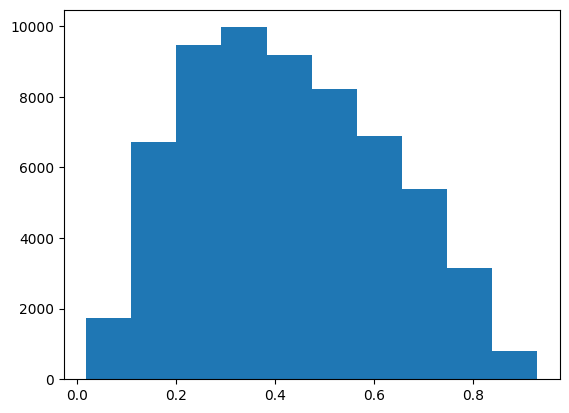

In [ ]:
# Calcul des probabilité de prédiction
clf = CalibratedClassifierCV(best_model_svm_gs)
clf.fit(X_train_eq,y_train_eq)
y_proba_svm = clf.predict_proba(X_test_norm)[:, 1]
plt.hist(y_proba_svm)

y_pred_svm=best_model_svm_gs.predict(X_test_norm)


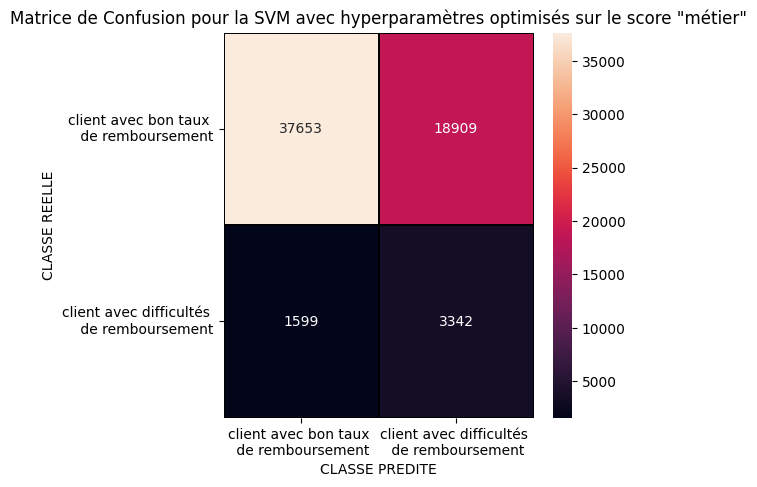

In [ ]:
# Graphique de la matrice de confusion
cm_svm = confusion_matrix(y_test, y_pred_svm)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la SVM avec hyperparamètres optimisés sur le score "métier"')
plt.show()

In [ ]:
# score de la SVM avec hyper-paramètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred_svm)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_svm)))
print('Recall Score : ' + str(recall_score(y_test, y_pred_svm)))
print('F1 Score : ' + str(f1_score(y_test, y_pred_svm)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test, y_pred_svm, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test, y_proba_svm)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_proba_svm)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_pred_svm)))

Accuracy Score : 0.666552851080435
Precision Score : 0.15019549683160308
Recall Score : 0.676381299332119
F1 Score : 0.24580759046778464
F beta Score (avec beta=3) : 0.5008992805755396
Aire sous la courbe ROC : 0.7353845136766455
Aire sous la courbe PR : 0.21191403195059594
Score de couts des erreurs de prédiction : 34899


Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser notre score "métier" créé sur les données d'entrainement non équilibrées.

In [ ]:
# probabilité des prédictiond sur les données d'entrainement avec les meilleurs hyperparamètres pour optimiser le seuil de décision
y_proba_svm_train = clf.predict_proba(X_train_norm)[:, 1]
y_pred_svm_train = best_model_svm_gs.predict(X_train_norm)


Best Threshold : 0.54
Best Score : 136771


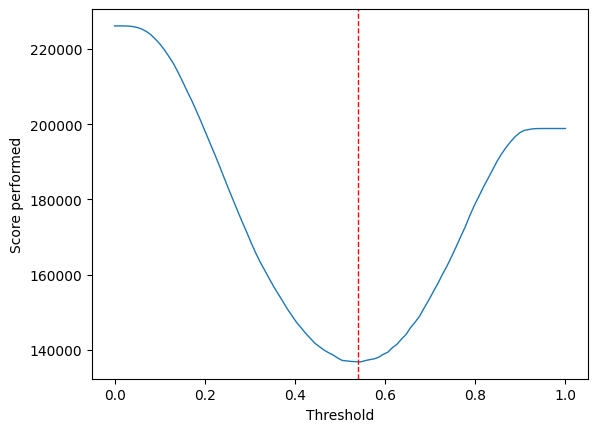

In [ ]:
threshold_selection_cout(y_proba_svm_train,y_train)

Evaluons ces hyper-paramètres ainsi que ce seuil optimisé sur les données de test :

In [ ]:
# prédiction sur les données de test avec les meilleurs hyperparamètres et le seuil optimisé avec le score "métier"
y_svm_opt_test = (clf.predict_proba(X_test_norm)[:,1] >= 0.54).astype(int)
y_svm_opt_proba_test = clf.predict_proba(X_test_norm)[:, 1]

In [ ]:
# score de la régression logistique avec hyperparamètres et seuil optimisés avec le score "métier"
print('Accuracy Score : ' + str(accuracy_score(y_test,y_svm_opt_test)))
print('Precision Score : ' + str(precision_score(y_test,y_svm_opt_test)))
print('Recall Score : ' + str(recall_score(y_test,y_svm_opt_test)))
print('F1 Score : ' + str(f1_score(y_test,y_svm_opt_test)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_svm_opt_test, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_svm_opt_test)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_svm_opt_test)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_svm_opt_test)))

Accuracy Score : 0.7192332081361885
Precision Score : 0.16427910016885452
Recall Score : 0.6104027524792552
F1 Score : 0.25888412017167384
F beta Score (avec beta=3) : 0.4800407461641306
Aire sous la courbe ROC : 0.6695714480192677
Aire sous la courbe PR : 0.13157570113156472
Score de couts des erreurs de prédiction : 34593


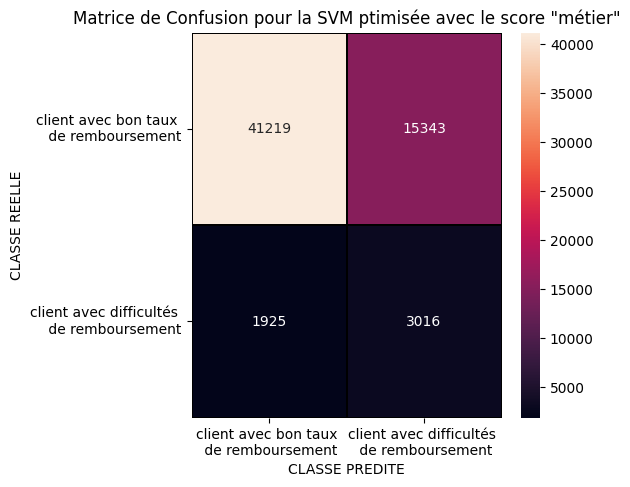

In [ ]:
# Graphique de la matrice de confusion
cm_svm = confusion_matrix(y_test, y_svm_opt_test)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la SVM ptimisée avec le score "métier"')
plt.show()

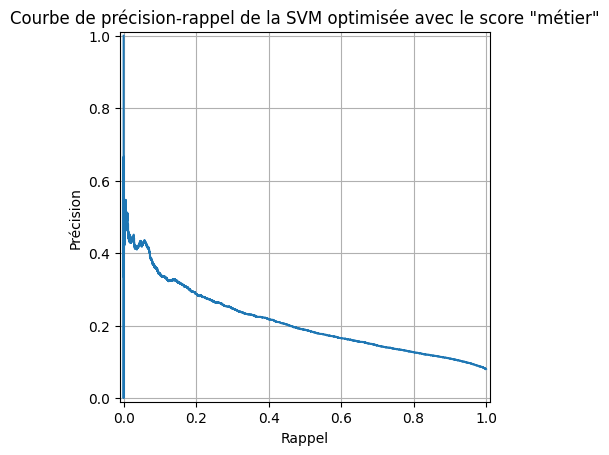

In [ ]:
# Graphique précision-rappel
precision_svm, recall_svm, _ = precision_recall_curve(y_test, y_svm_opt_proba_test)
disp_svm = PrecisionRecallDisplay(precision=precision_svm, recall=recall_svm)
disp_svm.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la SVM optimisée avec le score "métier"')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la SVM optimisée avec le score "métier"')

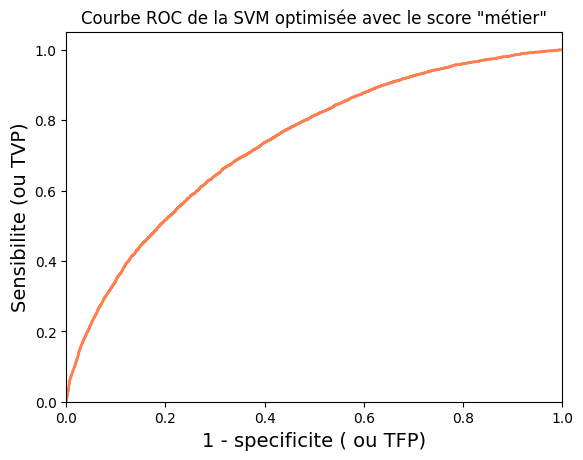

In [ ]:
# Graphique courbe ROC
[fpr_svm, tpr_svm, thr_svm] = metrics.roc_curve(y_test, y_svm_opt_proba_test)
plt.plot(fpr_svm, tpr_svm, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la SVM optimisée avec le score "métier"')

Text(0.5, 0, "Top 20 des variables avec le plus d'importance")

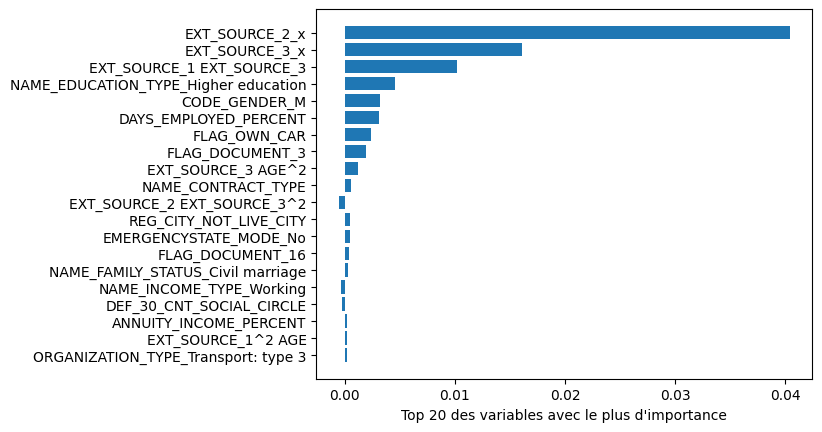

In [ ]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
perm_importance = permutation_importance(best_model_svm_gs,X_train_eq,y_train_eq)

feature_names = X_train_eq.columns
features = np.array(feature_names)

sorted_idx = abs(perm_importance.importances_mean).argsort()
plt.barh(features[sorted_idx[-20:]], perm_importance.importances_mean[sorted_idx[-20:]])
plt.xlabel("Top 20 des variables avec le plus d'importance")

Les variables "EXT_SOURCE_2", "EXT_SOURCE_3" ainsi que la combinaison polynomiale "EXT_SOURCE_1 EXT_SOURCE_3" sont les plus prédominantes dans ce modèle.


### Modèles non-linéaires de SVM à noyau:

 Afin de remédier au problème de l'absence de séparateur linéaire, on utilise un noyau (en anglais kernel) pour déplacer le problème dans un espace de dimension supérieure, éventuellement de dimension infinie.

 Dans ce nouvel espace, appelé espace de redescription, il est alors probable qu'il existe une séparation linéaire.

La fonction noyau choisie doit respecter certaines conditions : être symétrique et semi-définie positive. Cela peut être une fonction noyau polynômial ou exponentielle, ou gaussien(RBF),...

In [ ]:
pipeline_svm_noy=imbpipeline(steps=[
    ['classifier', SVC( tol=1e-5,max_iter=200,random_state=42,probability=True)]
])

params_svm_noy = {'classifier__kernel' :['poly', 'rbf', 'sigmoid'],'classifier__C': [0.001,0.01,0.1,1,10,100], 'classifier__gamma': ["scale", "auto"]}
scorer = {'main': 'accuracy', 'f1' : 'f1','custom': make_scorer(cout_score, greater_is_better=False)}

# optimisation des paramètres avec la grid search en fonction de notre score "métier"
grid_svm_noy = GridSearchCV(pipeline_svm_noy, params_svm_noy,scoring=scorer,refit='custom', cv=3, n_jobs=None)
grid_svm_noy.fit(X_train_eq,y_train_eq)

#récupération des meilleurs hyperparamètres
best_model_svm_noy_gs = grid_svm_noy.best_estimator_

In [ ]:
print(best_model_svm_noy_gs)

Pipeline(steps=[['classifier',
                 SVC(C=0.001, gamma='auto', kernel='poly', max_iter=200,
                     probability=True, random_state=42, tol=1e-05)]])


In [ ]:
cvres_svm_noy=pd.DataFrame(grid_svm_noy.cv_results_)
cvres_svm_noy

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       19.351054      1.286245         0.715194        0.195261   
1       24.181236      0.147943         1.494317        0.055815   
2       21.151011      0.681289         1.036438        0.092941   
3       20.095226      0.842222         0.716500        0.199410   
4       22.808165      0.717302         2.251748        0.356988   
5       23.029943      0.571464         0.801330        0.225802   
6       20.031681      1.241481         0.575198        0.187944   
7       23.256131      0.406367         2.332286        0.222378   
8       21.804161      0.745602         0.872819        0.168763   
9       19.776890      1.236443         0.654839        0.167299   
10      24.436712      0.298863         1.377427        0.066302   
11      22.102203      0.985811         0.956390        0.213811   
12      20.229275      0.944142         0.596671        0.207169   
13      22.660289      0.132985         2.449390        0.085469   
14      22.491384      0.718167         0.697711        0.086946   
15      19.646644      1.073784         0.665980        0.180813   
16      23.915514      0.767400         1.755888        0.456485   
17      21.183041      0.424241         0.917143        0.194847   
18      19.843137      1.323611         0.657995        0.165040   
19      23.698474      0.485014         1.552276        0.193240   
20      21.855453      1.019571         0.917761        0.203108   
21      20.022954      0.855137         0.573777        0.197414   
22      22.622014      0.238962         2.354985        0.015594   
23      22.806322      0.374523         0.713193        0.090446   
24      18.975380      1.385856         0.535759        0.185206   
25      22.217900      0.565688         2.327569        0.022497   
26      22.445503      0.877481         0.727501        0.123155   
27      18.935950      1.161274         0.692206        0.188830   
28      23.543840      0.255485         1.770825        0.454155   
29      21.303672      0.807755         0.863117        0.191672   
30      18.365337      1.326027         0.517834        0.162979   
31      23.033914      0.719108         1.684098        0.535926   
32      21.453053      0.572776         0.900339        0.176579   
33      18.242366      1.266500         0.516123        0.166904   
34      23.045671      0.672596         1.715461        0.489497   
35      21.400695      0.565913         0.902631        0.178694   

    param_classifier__C param_classifier__gamma param_classifier__kernel  \
0                 0.001                   scale                     poly   
1                 0.001                   scale                      rbf   
2                 0.001                   scale                  sigmoid   
3                 0.001                    auto                     poly   
4                 0.001                    auto                      rbf   
5                 0.001                    auto                  sigmoid   
6                 0.010                   scale                     poly   
7                 0.010                   scale                      rbf   
8                 0.010                   scale                  sigmoid   
9                 0.010                    auto                     poly   
10                0.010                    auto                      rbf   
11                0.010                    auto                  sigmoid   
12                0.100                   scale                     poly   
13                0.100                   scale                      rbf   
14                0.100                   scale                  sigmoid   
15                0.100                    auto                     poly   
16                0.100                    auto                      rbf   
17                0.100                    auto                  sigmoid   
18                1.000                   s

In [ ]:
cols= [i for i in cvres_svm_noy.columns if "split" not in i ]
cvres_svm_noy=cvres_svm_noy [cols].sort_values("rank_test_main")
cvres_svm_noy.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
13      22.660289      0.132985         2.449390        0.085469   
10      24.436712      0.298863         1.377427        0.066302   
7       23.256131      0.406367         2.332286        0.222378   
16      23.915514      0.767400         1.755888        0.456485   
26      22.445503      0.877481         0.727501        0.123155   
29      21.303672      0.807755         0.863117        0.191672   
4       22.808165      0.717302         2.251748        0.356988   
32      21.453053      0.572776         0.900339        0.176579   
1       24.181236      0.147943         1.494317        0.055815   
35      21.400695      0.565913         0.902631        0.178694   

    param_classifier__C param_classifier__gamma param_classifier__kernel  \
13                0.100                   scale                      rbf   
10                0.010                    auto                      rbf   
7                 0.010                   scale                      rbf   
16                0.100                    auto                      rbf   
26               10.000                   scale                  sigmoid   
29               10.000                    auto                  sigmoid   
4                 0.001                    auto                      rbf   
32              100.000                   scale                  sigmoid   
1                 0.001                   scale                      rbf   
35              100.000                    auto                  sigmoid   

                                               params  mean_test_main  \
13  {'classifier__C': 0.1, 'classifier__gamma': 's...        0.593719   
10  {'classifier__C': 0.01, 'classifier__gamma': '...        0.579964   
7   {'classifier__C': 0.01, 'classifier__gamma': '...        0.571540   
16  {'classifier__C': 0.1, 'classifier__gamma': 'a...        0.566913   
26  {'classifier__C': 10, 'classifier__gamma': 'sc...        0.552253   
29  {'classifier__C': 10, 'classifier__gamma': 'au...        0.550568   
4   {'classifier__C': 0.001, 'classifier__gamma': ...        0.544533   
32  {'classifier__C': 100, 'classifier__gamma': 's...        0.542597   
1   {'classifier__C': 0.001, 'classifier__gamma': ...        0.540057   
35  {'classifier__C': 100, 'classifier__gamma': 'a...        0.539152   

    std_test_main  rank_test_main  mean_test_f1  std_test_f1  rank_test_f1  \
13       0.006455               1      0.523461     0.015277            20   
10       0.024243               2      0.519525     0.044875            22   
7        0.018545               3      0.513662     0.041508            26   
16       0.016112               4      0.523650     0.022053            19   
26       0.026487               5      0.651787     0.003081            18   
29       0.031655               6      0.652568     0.005888            17   
4        0.056254               7      0.463457     0.107916            29   
32       0.028217               8      0.480606     0.148814            27   
1        0.052559               9      0.461418     0.106549            32   
35       0.032230              10      0.461988     0.175167            31   

    mean_test_custom  std_test_custom  rank_test_custom  
13     -38373.666667      1540.265201                28  
10     -37956.000000      3583.565915                26  
7      -38142.666667      3574.221252                27  
16     -36929.000000      2155.556695                25  
26     -15547.333333      3253.064641                18  
29     -15146.666667      4321.459347                17  
4      -41494.666667      7714.926888                32  
32     -35673.333333     17629.498165                23  
1      -41464.000000      7773.938041                31  
35     -36499.000000     18915.576773                24

In [ ]:
cols= [i for i in cvres_svm_noy.columns if "split" not in i ]
cvres_svm_noy=cvres_svm_noy [cols].sort_values("rank_test_f1")
cvres_svm_noy.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3       20.095226      0.842222         0.716500        0.199410   
0       19.351054      1.286245         0.715194        0.195261   
9       19.776890      1.236443         0.654839        0.167299   
6       20.031681      1.241481         0.575198        0.187944   
15      19.646644      1.073784         0.665980        0.180813   
12      20.229275      0.944142         0.596671        0.207169   
18      19.843137      1.323611         0.657995        0.165040   
27      18.935950      1.161274         0.692206        0.188830   
24      18.975380      1.385856         0.535759        0.185206   
21      20.022954      0.855137         0.573777        0.197414   

    param_classifier__C param_classifier__gamma param_classifier__kernel  \
3                 0.001                    auto                     poly   
0                 0.001                   scale                     poly   
9                 0.010                    auto                     poly   
6                 0.010                   scale                     poly   
15                0.100                    auto                     poly   
12                0.100                   scale                     poly   
18                1.000                   scale                     poly   
27               10.000                    auto                     poly   
24               10.000                   scale                     poly   
21                1.000                    auto                     poly   

                                               params  mean_test_main  \
3   {'classifier__C': 0.001, 'classifier__gamma': ...        0.500075   
0   {'classifier__C': 0.001, 'classifier__gamma': ...        0.500050   
9   {'classifier__C': 0.01, 'classifier__gamma': '...        0.500025   
6   {'classifier__C': 0.01, 'classifier__gamma': '...        0.499899   
15  {'classifier__C': 0.1, 'classifier__gamma': 'a...        0.500352   
12  {'classifier__C': 0.1, 'classifier__gamma': 's...        0.500302   
18  {'classifier__C': 1, 'classifier__gamma': 'sca...        0.502163   
27  {'classifier__C': 10, 'classifier__gamma': 'au...        0.503319   
24  {'classifier__C': 10, 'classifier__gamma': 'sc...        0.504074   
21  {'classifier__C': 1, 'classifier__gamma': 'aut...        0.501911   

    std_test_main  rank_test_main  mean_test_f1  std_test_f1  rank_test_f1  \
3        0.000062              31      0.666689     0.000016             1   
0        0.000071              32      0.666678     0.000016             2   
9        0.000178              33      0.666577     0.000123             3   
6        0.000128              34      0.666555     0.000111             4   
15       0.000291              29      0.666342     0.000206             5   
12       0.000185              30      0.666241     0.000124             6   
18       0.000094              27      0.666161     0.000193             7   
27       0.000686              26      0.665944     0.000642             8   
24       0.000710              25      0.665808     0.000226             9   
21       0.000155              28      0.665552     0.000253            10   

    mean_test_custom  std_test_custom  rank_test_custom  
3       -6630.000000         3.559026                 1  
0       -6630.333333         3.299832                 2  
9       -6654.666667        20.336065                 4  
6       -6647.333333        16.336734                 3  
15      -6752.333333        26.737406                 5  
12      -6774.000000        13.638182                 6  
18      -6992.333333        41.683996                 7  
27      -7172.000000       176.308442                 9  
24      -7288.000000        93.939697                10  
21      -7127.666667        50.972760                 8

In [ ]:
cols= [i for i in cvres_svm_noy.columns if "split" not in i ]
cvres_svm_noy=cvres_svm_noy [cols].sort_values("rank_test_custom")
cvres_svm_noy.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
3       20.095226      0.842222         0.716500        0.199410   
0       19.351054      1.286245         0.715194        0.195261   
6       20.031681      1.241481         0.575198        0.187944   
9       19.776890      1.236443         0.654839        0.167299   
15      19.646644      1.073784         0.665980        0.180813   
12      20.229275      0.944142         0.596671        0.207169   
18      19.843137      1.323611         0.657995        0.165040   
21      20.022954      0.855137         0.573777        0.197414   
27      18.935950      1.161274         0.692206        0.188830   
24      18.975380      1.385856         0.535759        0.185206   

    param_classifier__C param_classifier__gamma param_classifier__kernel  \
3                 0.001                    auto                     poly   
0                 0.001                   scale                     poly   
6                 0.010                   scale                     poly   
9                 0.010                    auto                     poly   
15                0.100                    auto                     poly   
12                0.100                   scale                     poly   
18                1.000                   scale                     poly   
21                1.000                    auto                     poly   
27               10.000                    auto                     poly   
24               10.000                   scale                     poly   

                                               params  mean_test_main  \
3   {'classifier__C': 0.001, 'classifier__gamma': ...        0.500075   
0   {'classifier__C': 0.001, 'classifier__gamma': ...        0.500050   
6   {'classifier__C': 0.01, 'classifier__gamma': '...        0.499899   
9   {'classifier__C': 0.01, 'classifier__gamma': '...        0.500025   
15  {'classifier__C': 0.1, 'classifier__gamma': 'a...        0.500352   
12  {'classifier__C': 0.1, 'classifier__gamma': 's...        0.500302   
18  {'classifier__C': 1, 'classifier__gamma': 'sca...        0.502163   
21  {'classifier__C': 1, 'classifier__gamma': 'aut...        0.501911   
27  {'classifier__C': 10, 'classifier__gamma': 'au...        0.503319   
24  {'classifier__C': 10, 'classifier__gamma': 'sc...        0.504074   

    std_test_main  rank_test_main  mean_test_f1  std_test_f1  rank_test_f1  \
3        0.000062              31      0.666689     0.000016             1   
0        0.000071              32      0.666678     0.000016             2   
6        0.000128              34      0.666555     0.000111             4   
9        0.000178              33      0.666577     0.000123             3   
15       0.000291              29      0.666342     0.000206             5   
12       0.000185              30      0.666241     0.000124             6   
18       0.000094              27      0.666161     0.000193             7   
21       0.000155              28      0.665552     0.000253            10   
27       0.000686              26      0.665944     0.000642             8   
24       0.000710              25      0.665808     0.000226             9   

    mean_test_custom  std_test_custom  rank_test_custom  
3       -6630.000000         3.559026                 1  
0       -6630.333333         3.299832                 2  
6       -6647.333333        16.336734                 3  
9       -6654.666667        20.336065                 4  
15      -6752.333333        26.737406                 5  
12      -6774.000000        13.638182                 6  
18      -6992.333333        41.683996                 7  
21      -7127.666667        50.972760                 8  
27      -7172.000000       176.308442                 9  
24      -7288.000000        93.939697                10

Les hyperparamètres optimisés correspondent au couple {'C': 0.001, 'gamma': auto, 'kernel': poly} et entrainent une maximisation  du mean_test_custom (= -1*cout_score) égal à -6630 avec un minimum de temps d'entrainement et de prédiction.


Evaluons ces hyper-paramètres sur le jeu de test :

In [ ]:
# best_model_svm_noy_gs=SVC(kernel ='rbf',C =0.01,gamma = "auto", tol=1e-5,max_iter=200,random_state=42,probability=True)
best_model_svm_noy_gs.fit(X_train_eq,y_train_eq)


Pipeline(steps=[['classifier',
                 SVC(C=0.001, gamma='auto', kernel='poly', max_iter=200,
                     probability=True, random_state=42, tol=1e-05)]])

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        3.0000e+00, 1.6000e+01, 4.6000e+01, 3.2000e+02, 6.1116e+04]),
 array([0.50809169, 0.50869666, 0.50930163, 0.5099066 , 0.51051157,
        0.51111653, 0.5117215 , 0.51232647, 0.51293144, 0.51353641,
        0.51414138]),
 <BarContainer object of 10 artists>)

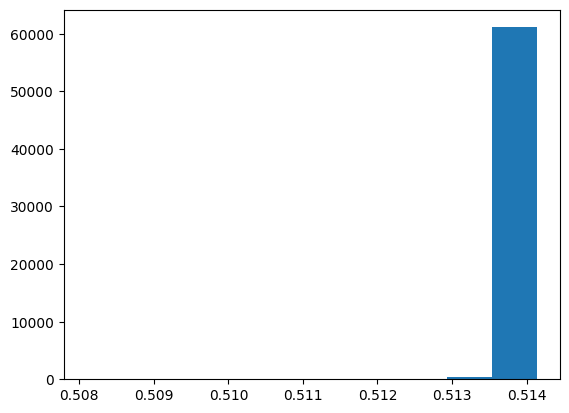

In [ ]:
y_proba_svm_noy=best_model_svm_noy_gs.predict_proba(X_test_norm)[:, 1]
y_pred_svm_noy=best_model_svm_noy_gs.predict(X_test_norm)
plt.hist(y_proba_svm_noy)

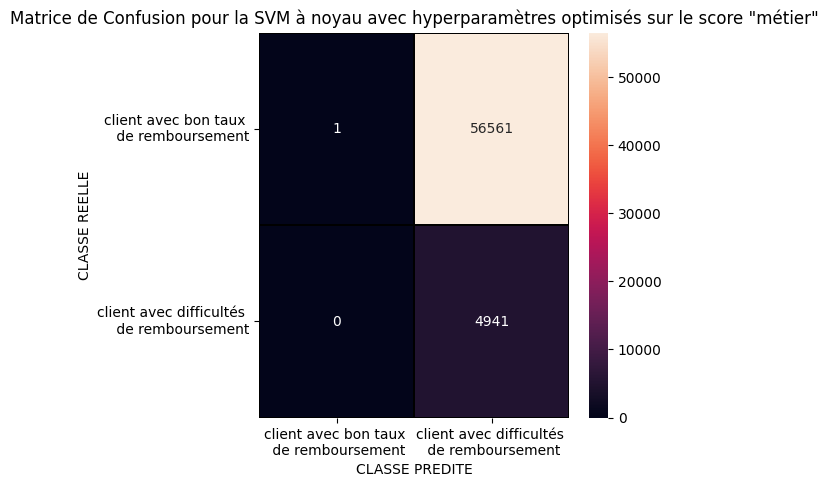

In [ ]:
# Graphique de la matrice de confusion
cm_svm_noy = confusion_matrix(y_test, y_pred_svm_noy)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm_noy, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la SVM à noyau avec hyperparamètres optimisés sur le score "métier"')
plt.show()

In [ ]:
# score de la SVM à noyau avec hyper-paramètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred_svm_noy)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_svm_noy)))
print('Recall Score : ' + str(recall_score(y_test, y_pred_svm_noy)))
print('F1 Score : ' + str(f1_score(y_test, y_pred_svm_noy)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test, y_pred_svm_noy, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test, y_proba_svm_noy)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_proba_svm_noy)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_pred_svm_noy)))

Accuracy Score : 0.08035380387948556
Precision Score : 0.08033885076908068
Recall Score : 1.0
F1 Score : 0.1487289857471818
F beta Score (avec beta=3) : 0.4662596370705193
Aire sous la courbe ROC : 0.6061533950407961
Aire sous la courbe PR : 0.1326794775766216
Score de couts des erreurs de prédiction : 56561


Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser notre score "métier" créé sur les données d'entrainement non équilibrées.

In [ ]:
# probabilité des prédictiond sur les données d'entrainement avec les meilleurs hyperparamètres pour optimiser le seuil de décision
y_proba_svm_noy_train = best_model_svm_noy_gs.predict_proba(X_train_norm)[:, 1]
y_pred_svm_noy_train = best_model_svm_noy_gs.predict(X_train_norm)

Best Threshold : 0.51
Best Score : 198840


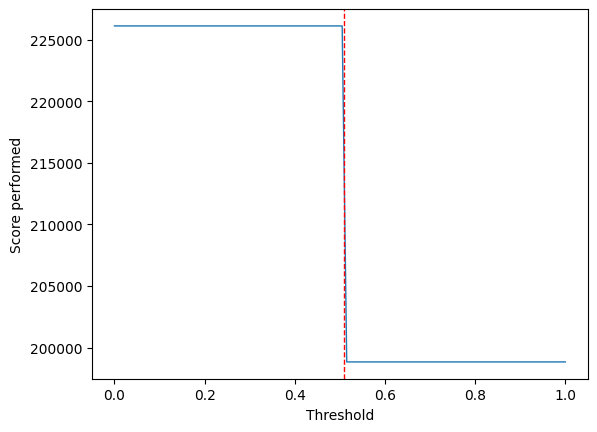

In [ ]:
threshold_selection_cout(y_proba_svm_noy_train,y_train)

Evaluons ces hyper-paramètres ainsi que ce seuil optimisé sur les données de test :

In [ ]:
# prédiction sur les données de test avec les meilleurs hyperparamètres et le seuil optimisé avec le score "métier"
y_svm_noy_opt_test = (best_model_svm_noy_gs.predict_proba(X_test_norm)[:,1] >= 0.51).astype(int)
y_svm_noy_opt_proba_test = best_model_svm_noy_gs.predict_proba(X_test_norm)[:, 1]

In [ ]:
# score de la régression logistique avec hyperparamètres et seuil optimisés avec le score "métier"
print('Accuracy Score : ' + str(accuracy_score(y_test,y_svm_noy_opt_test)))
print('Precision Score : ' + str(precision_score(y_test,y_svm_noy_opt_test)))
print('Recall Score : ' + str(recall_score(y_test,y_svm_noy_opt_test)))
print('F1 Score : ' + str(f1_score(y_test,y_svm_noy_opt_test)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_svm_noy_opt_test, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_svm_noy_opt_test)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_svm_noy_opt_test)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_svm_noy_opt_test)))

Accuracy Score : 0.08035380387948556
Precision Score : 0.08033885076908068
Recall Score : 1.0
F1 Score : 0.1487289857471818
F beta Score (avec beta=3) : 0.4662596370705193
Aire sous la courbe ROC : 0.5000088398571478
Aire sous la courbe PR : 0.08033885076908068
Score de couts des erreurs de prédiction : 56561


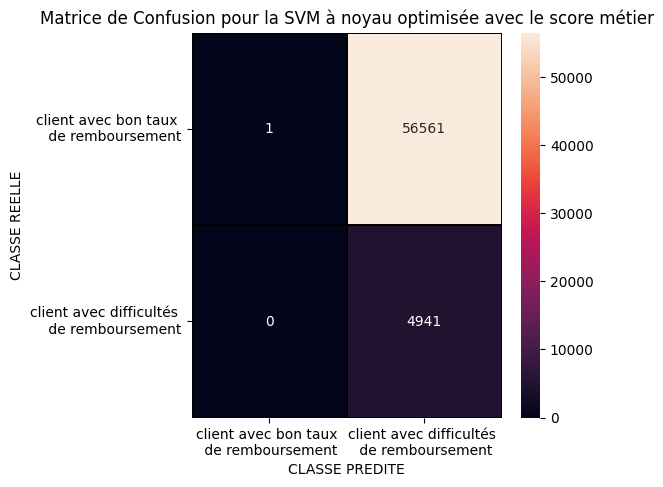

In [ ]:
# Graphique de la matrice de confusion
cm_svm_noy = confusion_matrix(y_test, y_svm_noy_opt_test)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_svm_noy, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la SVM à noyau optimisée avec le score métier')
plt.show()

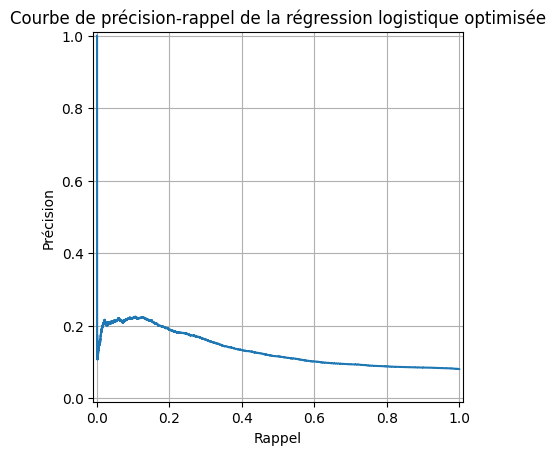

In [ ]:
# Graphique précision-rappel
precision_svm_noy, recall_svm_noy, _ = precision_recall_curve(y_test, y_svm_noy_opt_proba_test)
disp_svm_noy = PrecisionRecallDisplay(precision=precision_svm_noy, recall=recall_svm_noy)
disp_svm_noy.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la régression logistique optimisée')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la régression logistique optimisée')

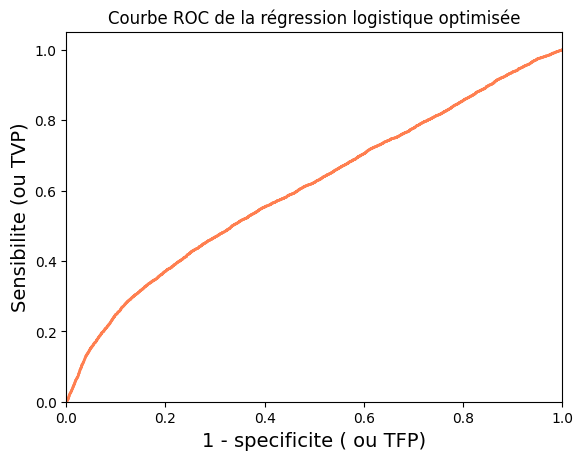

In [ ]:
# Graphique courbe ROC
[fpr_svm_noy, tpr_svm_noy, thr_svm_noy] = metrics.roc_curve(y_test, y_svm_noy_opt_proba_test)
plt.plot(fpr_svm_noy, tpr_svm_noy, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la régression logistique optimisée')

Text(0.5, 0, "Top 20 des variables avec le plus d'importance")

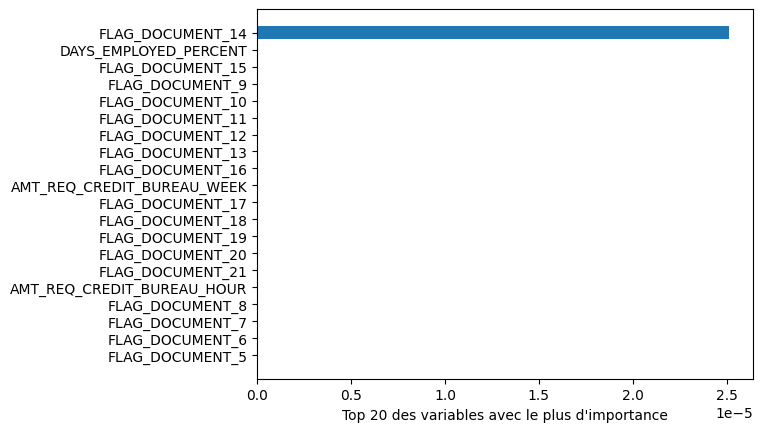

In [ ]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
perm_importance = permutation_importance(best_model_svm_noy_gs, X_train_eq,y_train_eq)

feature_names = X_train_eq.columns
features = np.array(feature_names)

sorted_idx = abs(perm_importance.importances_mean).argsort()
plt.barh(features[sorted_idx[-20:]], perm_importance.importances_mean[sorted_idx[-20:]])
plt.xlabel("Top 20 des variables avec le plus d'importance")

Ici c'est la variable "FLAG_DOCUMENT_14" qui  prédomine dans ce modèle.

### Modèles de réseaux de neurones:


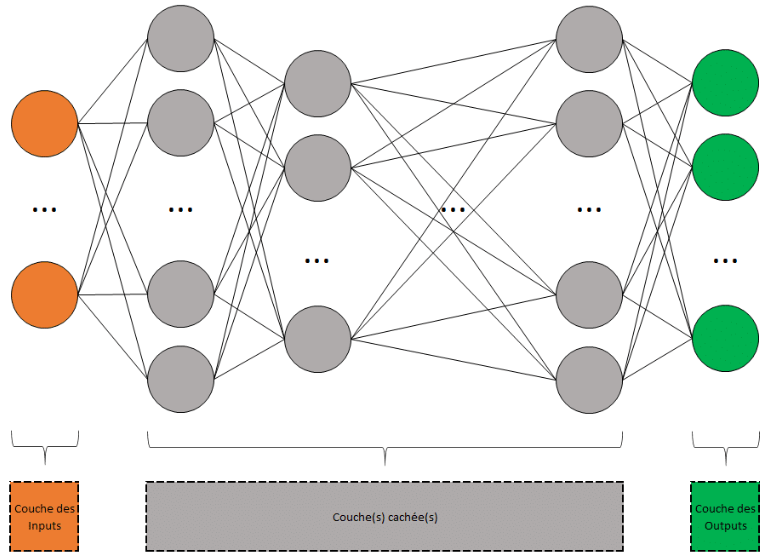

Dans un réseau, le neurone est une unité qui reçoit l'information, procède à des calculs simples, et la transmet à une autre unité. On distingue trois types de neurones dans un réseau artificiel :
- Les neurones d'entrées qui reçoivent les données du monde extérieur (couche d'entrée) ;
- Les neurones de traitement (couche cachée) ;
- Les neurones de sorties (couche de sortie).

Il permet d'apprendre des modèles de régression (la fonction d'activation est l'identité), de classification binaire (la fonction d'activation est la fonction logistique) ou de classification multi-classe (la fonction d'activation est la fonction softmax).

Chaque connexion a un poids spécifique qui influence la transmission de l'information d'une unité à une autre. Les informations provenant d'une connexion avec un poids important seront ainsi dominantes à l'entrée du neurone suivant, comparativement à celles provenant de connexions à poids faible. Ces dernières ne sont cependant pas ignorées lors du traitement de l'information. Les poids sont mis à jour de façon itérative grâce à l'algorithme du gradient.

L'entraînement de ces réseaux se fait par rétro-propagation. Attention, cet algorithme ne converge pas nécessairement, et pas nécessairement vers la solution optimale ! Plus il y a de paramètres, plus il faut de données pour pouvoir apprendre les valeurs de ces paramètres sans risquer le sur-apprentissage.

In [ ]:
def create_model():
    #Nous utilisons la fonction Sequential() qui est approprié pour notre problème(cf bibliothèque Keras: https://keras.io/guides/sequential_model/)
      model = tf.keras.Sequential()
      #On indique à notre modèle la dimension des données d'entrées qui correspond au nombre de colonnes de X_train, c'est à dire 276.
      model.add(tf.keras.layers.InputLayer(input_shape=[276]))
      #Première couche de notre réseau de neurones avec 276 perceptrons.
  #La fonction sigmoide est particulièrement indiqué pour les problèmes de classification.
      model.add(tf.keras.layers.Dense(276, input_dim=2, activation='sigmoid'))
      #Seconde couche car nous sommes dans un problème non linéaire
      model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
      model.compile(metrics=[tf.keras.metrics.Accuracy(name='my_accuracy'), tf.keras.metrics.Precision(name='my_precision'),tf.keras.metrics.Recall(name='my_recall'),tf.keras.metrics.F1Score( name="my_f1_score"),tf.keras.metrics.FBetaScore( beta=3.0, name="my_fbeta_score"),tf.keras.metrics.AUC(curve='ROC',name='my_aucroc'),tf.keras.metrics.AUC(curve='PR',name='my_aucpr'),tf.keras.metrics.FalsePositives(name="my_FP"),tf.keras.metrics.FalseNegatives(name="my_FN")],
                  loss="binary_crossentropy",
                  optimizer="adam")
      return model


In [ ]:
model = KerasClassifier(build_fn=create_model, verbose=0)


In [ ]:
custom_metric = make_scorer(cout_score, greater_is_better=False)

In [ ]:
pipeline_neuron=imbpipeline(steps=[
    ['classifier', model]
])

batch_size = [50,100, 100,150,200]
epochs = [10, 50, 100]
params_neuron = dict(classifier__batch_size=batch_size, classifier__epochs=epochs)
scorer = {'main': 'accuracy', 'f1' : 'f1','custom':custom_metric}

# optimisation des paramètres avec la grid search en fonction de notre score "métier"
grid_neuron = GridSearchCV(pipeline_neuron, params_neuron, scoring=scorer, refit='custom', cv=3, n_jobs=None)
grid_neuron.fit(X_train_eq,y_train_eq)

#récupération des meilleurs hyperparamètres
best_model_neuron_gs = grid_neuron.best_estimator_


In [ ]:
print(best_model_neuron_gs)

Pipeline(steps=[['classifier',
                 KerasClassifier(batch_size=100, build_fn=<function create_model at 0x78a53f3fd1b0>, epochs=10, verbose=0)]])


In [ ]:
cvres_neuron=pd.DataFrame(grid_neuron.cv_results_)
cvres_neuron

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       26.099092      1.987554         1.144383        0.218349   
1      121.474287      3.570107         0.856634        0.187715   
2      235.874166     11.164525         0.985129        0.359098   
3       18.669818      1.861433         0.627481        0.152347   
4       83.404950      0.561938         0.697682        0.183325   
5      157.324602      4.068698         0.678699        0.170466   
6       18.553289      2.137045         0.551689        0.178648   
7       82.069907      1.628029         0.602087        0.116635   
8      157.560723      1.195185         0.422384        0.009596   
9       14.955845      3.758699         0.530008        0.201465   
10      58.015156      4.266549         0.819030        0.017594   
11     128.549355     10.915192         0.564012        0.122266   
12      11.160310      1.448489         0.504796        0.226291   
13      46.712081      2.338504         0.561041        0.199881   
14      89.976935      1.524720         0.560640        0.184817   

    param_classifier__batch_size  param_classifier__epochs  \
0                             50                        10   
1                             50                        50   
2                             50                       100   
3                            100                        10   
4                            100                        50   
5                            100                       100   
6                            100                        10   
7                            100                        50   
8                            100                       100   
9                            150                        10   
10                           150                        50   
11                           150                       100   
12                           200                        10   
13                           200                        50   
14                           200                       100   

                                               params  split0_test_main  \
0   {'classifier__batch_size': 50, 'classifier__ep...          0.679315   
1   {'classifier__batch_size': 50, 'classifier__ep...          0.617230   
2   {'classifier__batch_size': 50, 'classifier__ep...          0.616023   
3   {'classifier__batch_size': 100, 'classifier__e...          0.679089   
4   {'classifier__batch_size': 100, 'classifier__e...          0.634128   
5   {'classifier__batch_size': 100, 'classifier__e...          0.621379   
6   {'classifier__batch_size': 100, 'classifier__e...          0.673884   
7   {'classifier__batch_size': 100, 'classifier__e...          0.632770   
8   {'classifier__batch_size': 100, 'classifier__e...          0.627112   
9   {'classifier__batch_size': 150, 'classifier__e...          0.680447   
10  {'classifier__batch_size': 150, 'classifier__e...          0.632016   
11  {'classifier__batch_size': 150, 'classifier__e...          0.620172   
12  {'classifier__batch_size': 200, 'classifier__e...          0.677731   
13  {'classifier__batch_size': 200, 'classifier__e...          0.637598   
14  {'classifier__batch_size': 200, 'classifier__e...          0.624246   

    split1_test_main  split2_test_main  ...  split2_test_f1  mean_test_f1  \
0           0.680371          0.673959  ...        0.678039      0.679205   
1           0.625302          0.625604  ...        0.627933      0.620824   
2           0.625075          0.617456  ...        0.618750      0.619651   
3           0.684294          0.676373  ...        0.680709      0.679884   
4           0.631186          0.615344  ...        0.603592      0.620629   
5           0.619870          0.630658  ...        0.634190      0.623874   
6           0.680748          0.675996  ...        0.678060      0.684711   
7           0.638654          0.635788  ...        0.643743      0.641054   
8           0.624396        

In [ ]:
cols= [i for i in cvres_neuron.columns if "split" not in i ]
cvres_neuron=cvres_neuron [cols].sort_values("rank_test_main")
cvres_neuron.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
9       14.955845      3.758699         0.530008        0.201465   
3       18.669818      1.861433         0.627481        0.152347   
12      11.160310      1.448489         0.504796        0.226291   
0       26.099092      1.987554         1.144383        0.218349   
6       18.553289      2.137045         0.551689        0.178648   
13      46.712081      2.338504         0.561041        0.199881   
7       82.069907      1.628029         0.602087        0.116635   
10      58.015156      4.266549         0.819030        0.017594   
4       83.404950      0.561938         0.697682        0.183325   
14      89.976935      1.524720         0.560640        0.184817   

    param_classifier__batch_size  param_classifier__epochs  \
9                            150                        10   
3                            100                        10   
12                           200                        10   
0                             50                        10   
6                            100                        10   
13                           200                        50   
7                            100                        50   
10                           150                        50   
4                            100                        50   
14                           200                       100   

                                               params  mean_test_main  \
9   {'classifier__batch_size': 150, 'classifier__e...        0.680170   
3   {'classifier__batch_size': 100, 'classifier__e...        0.679919   
12  {'classifier__batch_size': 200, 'classifier__e...        0.678988   
0   {'classifier__batch_size': 50, 'classifier__ep...        0.677882   
6   {'classifier__batch_size': 100, 'classifier__e...        0.676876   
13  {'classifier__batch_size': 200, 'classifier__e...        0.641471   
7   {'classifier__batch_size': 100, 'classifier__e...        0.635737   
10  {'classifier__batch_size': 150, 'classifier__e...        0.632669   
4   {'classifier__batch_size': 100, 'classifier__e...        0.626886   
14  {'classifier__batch_size': 200, 'classifier__e...        0.625251   

    std_test_main  rank_test_main  mean_test_f1  std_test_f1  rank_test_f1  \
9        0.002748               1      0.678742     0.010378             5   
3        0.003287               2      0.679884     0.009158             3   
12       0.002677               3      0.683614     0.002883             2   
0        0.002807               4      0.679205     0.001623             4   
6        0.002871               5      0.684711     0.004853             1   
13       0.002978               6      0.638128     0.003537             7   
7        0.002402               7      0.641054     0.006625             6   
10       0.001905               8      0.628729     0.011547             9   
4        0.008249               9      0.620629     0.012076            12   
14       0.003582              10      0.629088     0.005736             8   

    mean_test_custom  std_test_custom  rank_test_custom  
9      -23535.666667      1653.500193                 5  
3      -23305.000000      1495.989305                 4  
12     -22531.333333       299.562273                 2  
0      -23239.000000       264.213298                 3  
6      -22061.333333      1009.207720                 1  
13     -26688.666667       412.337510                 7  
7      -25660.666667       895.604948                 6  
10     -27366.333333      1666.784796                 9  
4      -28169.000000      1162.795769                14  
14     -26699.666667       619.166285                 8

In [ ]:
cols= [i for i in cvres_neuron.columns if "split" not in i ]
cvres_neuron=cvres_neuron [cols].sort_values("rank_test_f1")
cvres_neuron.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
6       18.553289      2.137045         0.551689        0.178648   
12      11.160310      1.448489         0.504796        0.226291   
3       18.669818      1.861433         0.627481        0.152347   
0       26.099092      1.987554         1.144383        0.218349   
9       14.955845      3.758699         0.530008        0.201465   
7       82.069907      1.628029         0.602087        0.116635   
13      46.712081      2.338504         0.561041        0.199881   
14      89.976935      1.524720         0.560640        0.184817   
10      58.015156      4.266549         0.819030        0.017594   
5      157.324602      4.068698         0.678699        0.170466   

    param_classifier__batch_size  param_classifier__epochs  \
6                            100                        10   
12                           200                        10   
3                            100                        10   
0                             50                        10   
9                            150                        10   
7                            100                        50   
13                           200                        50   
14                           200                       100   
10                           150                        50   
5                            100                       100   

                                               params  mean_test_main  \
6   {'classifier__batch_size': 100, 'classifier__e...        0.676876   
12  {'classifier__batch_size': 200, 'classifier__e...        0.678988   
3   {'classifier__batch_size': 100, 'classifier__e...        0.679919   
0   {'classifier__batch_size': 50, 'classifier__ep...        0.677882   
9   {'classifier__batch_size': 150, 'classifier__e...        0.680170   
7   {'classifier__batch_size': 100, 'classifier__e...        0.635737   
13  {'classifier__batch_size': 200, 'classifier__e...        0.641471   
14  {'classifier__batch_size': 200, 'classifier__e...        0.625251   
10  {'classifier__batch_size': 150, 'classifier__e...        0.632669   
5   {'classifier__batch_size': 100, 'classifier__e...        0.623969   

    std_test_main  rank_test_main  mean_test_f1  std_test_f1  rank_test_f1  \
6        0.002871               5      0.684711     0.004853             1   
12       0.002677               3      0.683614     0.002883             2   
3        0.003287               2      0.679884     0.009158             3   
0        0.002807               4      0.679205     0.001623             4   
9        0.002748               1      0.678742     0.010378             5   
7        0.002402               7      0.641054     0.006625             6   
13       0.002978               6      0.638128     0.003537             7   
14       0.003582              10      0.629088     0.005736             8   
10       0.001905               8      0.628729     0.011547             9   
5        0.004770              12      0.623874     0.008090            10   

    mean_test_custom  std_test_custom  rank_test_custom  
6      -22061.333333      1009.207720                 1  
12     -22531.333333       299.562273                 2  
3      -23305.000000      1495.989305                 4  
0      -23239.000000       264.213298                 3  
9      -23535.666667      1653.500193                 5  
7      -25660.666667       895.604948                 6  
13     -26688.666667       412.337510                 7  
14     -26699.666667       619.166285                 8  
10     -27366.333333      1666.784796                 9  
5      -27418.666667       901.165665                10

In [ ]:
cols= [i for i in cvres_neuron.columns if "split" not in i ]
cvres_neuron=cvres_neuron [cols].sort_values("rank_test_custom")
cvres_neuron.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
6       18.553289      2.137045         0.551689        0.178648   
12      11.160310      1.448489         0.504796        0.226291   
0       26.099092      1.987554         1.144383        0.218349   
3       18.669818      1.861433         0.627481        0.152347   
9       14.955845      3.758699         0.530008        0.201465   
7       82.069907      1.628029         0.602087        0.116635   
13      46.712081      2.338504         0.561041        0.199881   
14      89.976935      1.524720         0.560640        0.184817   
10      58.015156      4.266549         0.819030        0.017594   
5      157.324602      4.068698         0.678699        0.170466   

    param_classifier__batch_size  param_classifier__epochs  \
6                            100                        10   
12                           200                        10   
0                             50                        10   
3                            100                        10   
9                            150                        10   
7                            100                        50   
13                           200                        50   
14                           200                       100   
10                           150                        50   
5                            100                       100   

                                               params  mean_test_main  \
6   {'classifier__batch_size': 100, 'classifier__e...        0.676876   
12  {'classifier__batch_size': 200, 'classifier__e...        0.678988   
0   {'classifier__batch_size': 50, 'classifier__ep...        0.677882   
3   {'classifier__batch_size': 100, 'classifier__e...        0.679919   
9   {'classifier__batch_size': 150, 'classifier__e...        0.680170   
7   {'classifier__batch_size': 100, 'classifier__e...        0.635737   
13  {'classifier__batch_size': 200, 'classifier__e...        0.641471   
14  {'classifier__batch_size': 200, 'classifier__e...        0.625251   
10  {'classifier__batch_size': 150, 'classifier__e...        0.632669   
5   {'classifier__batch_size': 100, 'classifier__e...        0.623969   

    std_test_main  rank_test_main  mean_test_f1  std_test_f1  rank_test_f1  \
6        0.002871               5      0.684711     0.004853             1   
12       0.002677               3      0.683614     0.002883             2   
0        0.002807               4      0.679205     0.001623             4   
3        0.003287               2      0.679884     0.009158             3   
9        0.002748               1      0.678742     0.010378             5   
7        0.002402               7      0.641054     0.006625             6   
13       0.002978               6      0.638128     0.003537             7   
14       0.003582              10      0.629088     0.005736             8   
10       0.001905               8      0.628729     0.011547             9   
5        0.004770              12      0.623874     0.008090            10   

    mean_test_custom  std_test_custom  rank_test_custom  
6      -22061.333333      1009.207720                 1  
12     -22531.333333       299.562273                 2  
0      -23239.000000       264.213298                 3  
3      -23305.000000      1495.989305                 4  
9      -23535.666667      1653.500193                 5  
7      -25660.666667       895.604948                 6  
13     -26688.666667       412.337510                 7  
14     -26699.666667       619.166285                 8  
10     -27366.333333      1666.784796                 9  
5      -27418.666667       901.165665                10

Les hyperparamètres optimisés correspondent au couple {'batch_size': 100, 'epochs': 10} et entrainent une maximisation  du mean_test_custom (= -1*cout_score) égal à -22061.33 avec un temps d'entrainement et de prédiction peu élevé.


Evaluons ces hyper-paramètres sur le jeu de test :

In [ ]:
best_model_neuron_gs.fit(X_train_eq,y_train_eq)

Pipeline(steps=[['classifier',
                 KerasClassifier(batch_size=100, build_fn=<function create_model at 0x78a53f3fd1b0>, epochs=10, verbose=0)]])

(array([  879.,  6792., 10918., 11152.,  9815.,  8603.,  6677.,  4535.,
         2012.,   120.]),
 array([0.00738717, 0.10651911, 0.20565106, 0.30478302, 0.40391496,
        0.50304693, 0.60217887, 0.70131081, 0.80044276, 0.8995747 ,
        0.99870664]),
 <BarContainer object of 10 artists>)

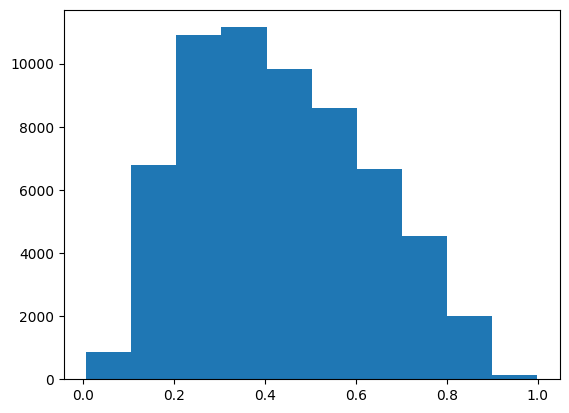

In [ ]:
y_proba_neuron=best_model_neuron_gs.predict_proba(X_test_norm)[:, 1]
y_pred_neuron=best_model_neuron_gs.predict(X_test_norm)
plt.hist(y_proba_neuron)

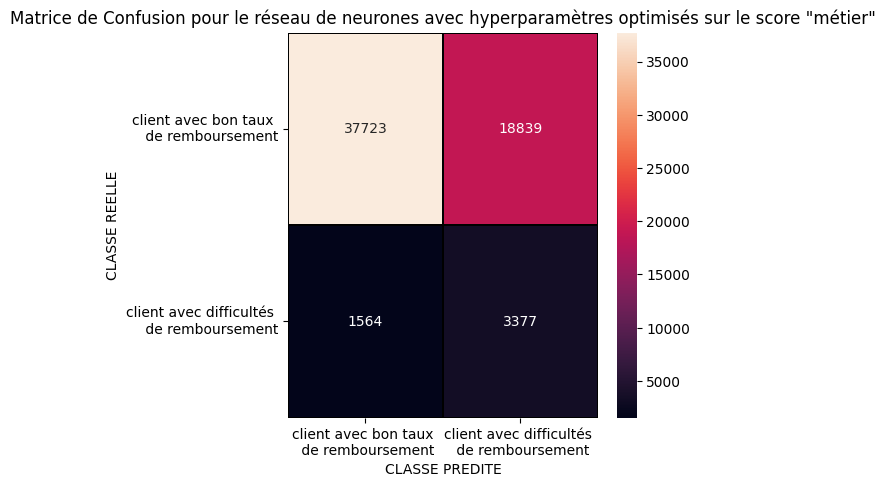

In [ ]:
# Graphique de la matrice de confusion
cm_neuron = confusion_matrix(y_test, y_pred_neuron)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_neuron, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le réseau de neurones avec hyperparamètres optimisés sur le score "métier"')
plt.show()

In [ ]:
# score du réseau de neurone avec hyper-paramètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred_neuron)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_neuron)))
print('Recall Score : ' + str(recall_score(y_test, y_pred_neuron)))
print('F1 Score : ' + str(f1_score(y_test, y_pred_neuron)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test, y_pred_neuron, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test, y_proba_neuron)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_proba_neuron)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_pred_neuron)))

Accuracy Score : 0.6682600848739086
Precision Score : 0.15200756211739286
Recall Score : 0.683464885650678
F1 Score : 0.2487019921198954
F beta Score (avec beta=3) : 0.506410737047312
Aire sous la courbe ROC : 0.7369751995437182
Aire sous la courbe PR : 0.2092892272478467
Score de couts des erreurs de prédiction : 34479


Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser notre score "métier" créé sur les données d'entrainement non équilibrées.

In [ ]:
# probabilité des prédictiond sur les données d'entrainement avec les meilleurs hyperparamètres pour optimiser le seuil de décision
y_proba_neuron_train = best_model_neuron_gs.predict_proba(X_train_norm)[:, 1]
y_pred_neuron_train = best_model_neuron_gs.predict(X_train_norm)


Best Threshold : 0.53
Best Score : 129402


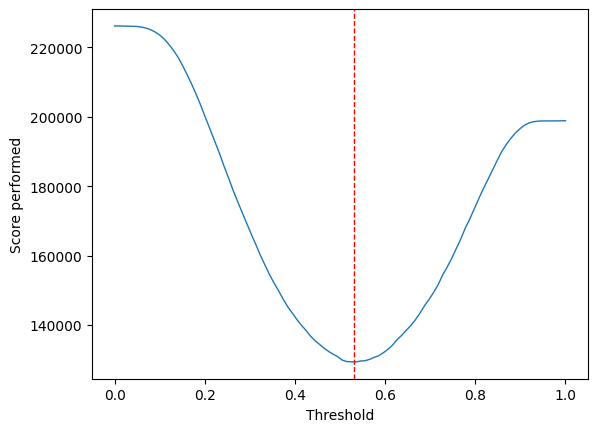

In [ ]:
threshold_selection_cout(y_proba_neuron_train,y_train)

Evaluons ces hyper-paramètres ainsi que ce seuil optimisé sur les données de test :

In [ ]:
# prédiction sur les données de test avec les meilleurs hyperparamètres et le seuil optimisé avec le score "métier"
y_neuron_opt_test = (best_model_neuron_gs.predict_proba(X_test_norm)[:,1] >= 0.53).astype(int)
y_neuron_opt_proba_test = best_model_neuron_gs.predict_proba(X_test_norm)[:, 1]

In [ ]:
# score du réseau de neurones avec hyperparamètres et seuil optimisés avec le score "métier"
print('Accuracy Score : ' + str(accuracy_score(y_test,y_neuron_opt_test)))
print('Precision Score : ' + str(precision_score(y_test,y_neuron_opt_test)))
print('Recall Score : ' + str(recall_score(y_test,y_neuron_opt_test)))
print('F1 Score : ' + str(f1_score(y_test,y_neuron_opt_test)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_neuron_opt_test, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_neuron_opt_test)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_neuron_opt_test)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_neuron_opt_test)))

Accuracy Score : 0.7048761849015495
Precision Score : 0.1610386944472955
Recall Score : 0.6350941105039466
F1 Score : 0.25692880828591314
F beta Score (avec beta=3) : 0.4906574935501524
Aire sous la courbe ROC : 0.6730330705979652
Aire sous la courbe PR : 0.13159036954608103
Score de couts des erreurs de prédiction : 34378


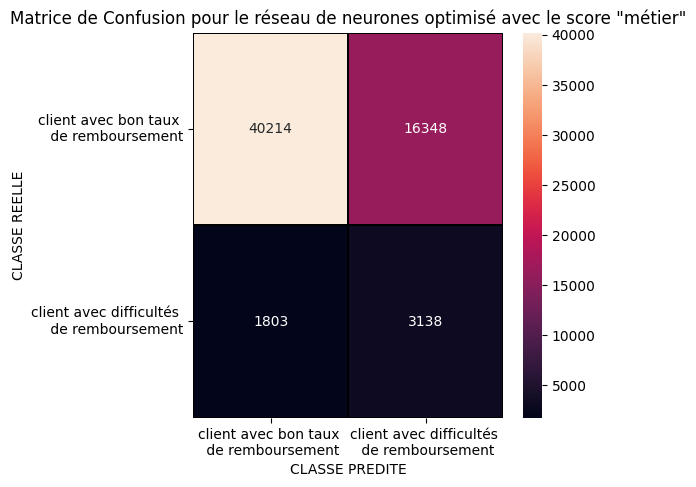

In [ ]:
# Graphique de la matrice de confusion
cm_neuron = confusion_matrix(y_test, y_neuron_opt_test)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_neuron, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le réseau de neurones optimisé avec le score "métier"')
plt.show()

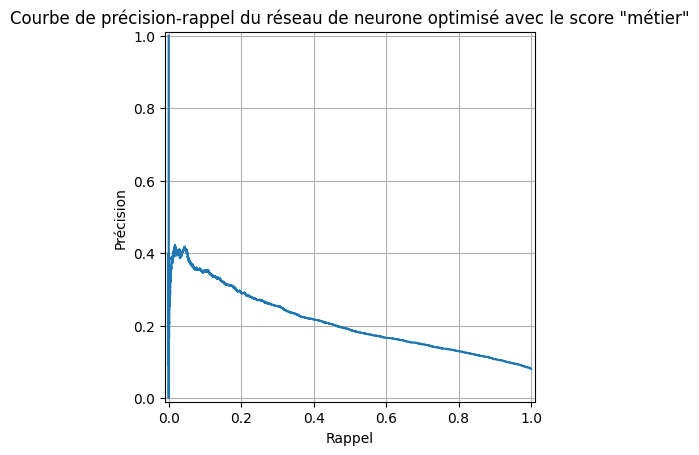

In [ ]:
# Graphique précision-rappel
precision_neuron, recall_neuron, _ = precision_recall_curve(y_test, y_neuron_opt_proba_test)
disp_neuron = PrecisionRecallDisplay(precision=precision_neuron, recall=recall_neuron)
disp_neuron.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel du réseau de neurone optimisé avec le score "métier"')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC du réseau de neurone optimisé avec le score "métier"')

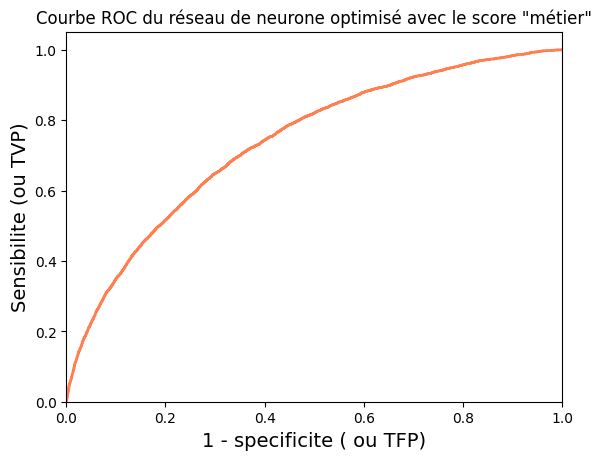

In [ ]:
# Graphique courbe ROC
[fpr_neuron, tpr_neuron, thr_neuron] = metrics.roc_curve(y_test, y_neuron_opt_proba_test)
plt.plot(fpr_neuron, tpr_neuron, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC du réseau de neurone optimisé avec le score "métier"')

Text(0.5, 0, "Top 20 des variables avec le plus d'importance")

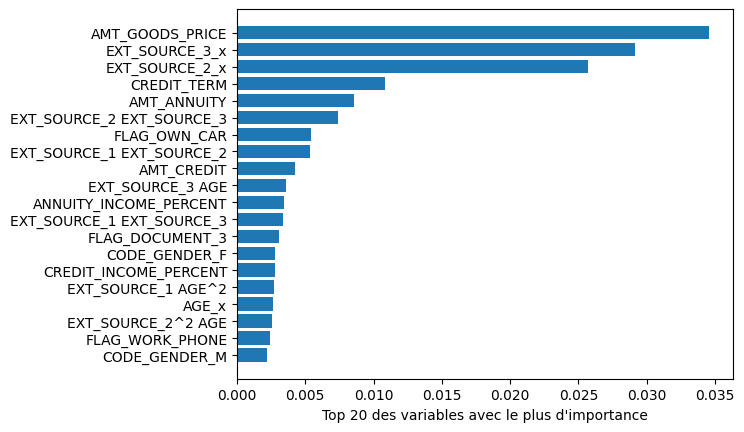

In [ ]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
perm_importance_neuron = permutation_importance(best_model_neuron_gs, X_train_eq,y_train_eq)

feature_names = X_train_eq.columns
features = np.array(feature_names)

sorted_idx_neuron = abs(perm_importance_neuron.importances_mean).argsort()
plt.barh(features[sorted_idx_neuron[-20:]], perm_importance_neuron.importances_mean[sorted_idx_neuron[-20:]])
plt.xlabel("Top 20 des variables avec le plus d'importance")

Ici c'est la variable "AMT_GOODS_PRICE" correspondant au montant du bien pour lequel le prêt a été contacté qui est prédominante. Les  variables "EXT_SOURCE_2","EXT_SOURCE_3","CREDIT_TERM" et "AMT_ANNUITY" sont également importante dans ce modèle.

### Modèles ensembliste de forêts aléatoires (Random Forest):


La base du calcul repose sur l'apprentissage par arbres de décision partiellement indépendants les uns des autres.

Pour chaque arbre à créer :

- On crée un échantillon en tirant avec remise autant d'observations que le jeu de données inital (technique connue sous le nom de  bagging, aussi appelé bootstrap aggregating ),
- Sur toutes les variables, on n'en retient qu'un plus petit nombre au hasard.
- On entraîne un arbre de décision à partir de l'échantillon créé en ne tenant compte que des variables sélectionnées. On limite la croissance de l'arbre de décision par validation croisée.

In [ ]:
pipeline_rfc=imbpipeline(steps=[
    ['classifier', RandomForestClassifier(random_state=42)]
])

params_rfc = {"classifier__max_depth": [None] + list(range(2, 20, 3)),"classifier__max_features": ["sqrt", "log2"]}
scorer = {'main': 'accuracy', 'f1' : 'f1','custom': make_scorer(cout_score, greater_is_better=False)}

# optimisation des paramètres avec la grid search en fonction de notre score "métier"
grid_rfc = GridSearchCV(pipeline_rfc, params_rfc,scoring=scorer,refit='custom', cv=3, n_jobs=None)
grid_rfc.fit(X_train_eq,y_train_eq)

#récupération des meilleurs hyperparamètres
best_model_rfc_gs = grid_rfc.best_estimator_

In [ ]:
print(best_model_rfc_gs)

Pipeline(steps=[['classifier',
                 RandomForestClassifier(max_depth=17, max_features='log2',
                                        random_state=42)]])


In [ ]:
cvres_rfc=pd.DataFrame(grid_rfc.cv_results_)
cvres_rfc

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       24.363747      0.294486         0.516696        0.011958   
1       12.841123      1.508040         0.727073        0.096827   
2        3.296536      0.035322         0.119762        0.006611   
3        1.671616      0.312051         0.091497        0.018099   
4        6.453993      0.970650         0.159090        0.022549   
5        3.385682      0.634546         0.139838        0.030808   
6        9.923545      1.366697         0.209968        0.045889   
7        6.169783      0.247260         0.272182        0.050789   
8       13.448202      1.275210         0.354367        0.068581   
9        7.312364      1.010214         0.378453        0.073871   
10      17.237872      1.157685         0.414653        0.101117   
11       9.212104      1.203672         0.471199        0.098408   
12      20.014092      1.071510         0.577611        0.104512   
13      11.113014      1.456748         0.573536        0.116135   

   param_classifier__max_depth param_classifier__max_features  \
0                         None                           sqrt   
1                         None                           log2   
2                            2                           sqrt   
3                            2                           log2   
4                            5                           sqrt   
5                            5                           log2   
6                            8                           sqrt   
7                            8                           log2   
8                           11                           sqrt   
9                           11                           log2   
10                          14                           sqrt   
11                          14                           log2   
12                          17                           sqrt   
13                          17                           log2   

                                               params  split0_test_main  \
0   {'classifier__max_depth': None, 'classifier__m...          0.678636   
1   {'classifier__max_depth': None, 'classifier__m...          0.675694   
2   {'classifier__max_depth': 2, 'classifier__max_...          0.663624   
3   {'classifier__max_depth': 2, 'classifier__max_...          0.664077   
4   {'classifier__max_depth': 5, 'classifier__max_...          0.671319   
5   {'classifier__max_depth': 5, 'classifier__max_...          0.670263   
6   {'classifier__max_depth': 8, 'classifier__max_...          0.674713   
7   {'classifier__max_depth': 8, 'classifier__max_...          0.672903   
8   {'classifier__max_depth': 11, 'classifier__max...          0.676750   
9   {'classifier__max_depth': 11, 'classifier__max...          0.675619   
10  {'classifier__max_depth': 14, 'classifier__max...          0.676222   
11  {'classifier__max_depth': 14, 'classifier__max...          0.677278   
12  {'classifier__max_depth': 17, 'classifier__max...          0.675166   
13  {'classifier__max_depth': 17, 'classifier__max...          0.679617   

    split1_test_main  split2_test_main  ...  split2_test_f1  mean_test_f1  \
0           0.675920          0.670338  ...        0.662496      0.668412   
1           0.674261          0.666038  ...        0.658858      0.665713   
2           0.665887          0.654345  ...        0.649050      0.657678   
3           0.666264          0.658570  ...        0.653870      0.661193   
4           0.671545          0.661135  ...        0.655151      0.662873   
5           0.673959          0.661889  ...        0.657967      0.666477   
6           0.677354          0.669282  ...        0.664934      0.670467   
7           0.677806          0.668754  ...        0.664784      0.669831   
8           0.679919          0.670338  ...        0.667276      0.673557   
9           0.682559          0.668452  ...        0.664734      0.672782   
10          0.677505          0.67

In [ ]:
cols= [i for i in cvres_rfc.columns if "split" not in i ]
cvres_rfc=cvres_rfc [cols].sort_values("rank_test_main")
cvres_rfc.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
13      11.113014      1.456748         0.573536        0.116135   
11       9.212104      1.203672         0.471199        0.098408   
8       13.448202      1.275210         0.354367        0.068581   
9        7.312364      1.010214         0.378453        0.073871   
12      20.014092      1.071510         0.577611        0.104512   
10      17.237872      1.157685         0.414653        0.101117   
0       24.363747      0.294486         0.516696        0.011958   
6        9.923545      1.366697         0.209968        0.045889   
7        6.169783      0.247260         0.272182        0.050789   
1       12.841123      1.508040         0.727073        0.096827   

   param_classifier__max_depth param_classifier__max_features  \
13                          17                           log2   
11                          14                           log2   
8                           11                           sqrt   
9                           11                           log2   
12                          17                           sqrt   
10                          14                           sqrt   
0                         None                           sqrt   
6                            8                           sqrt   
7                            8                           log2   
1                         None                           log2   

                                               params  mean_test_main  \
13  {'classifier__max_depth': 17, 'classifier__max...        0.678435   
11  {'classifier__max_depth': 14, 'classifier__max...        0.676775   
8   {'classifier__max_depth': 11, 'classifier__max...        0.675669   
9   {'classifier__max_depth': 11, 'classifier__max...        0.675543   
12  {'classifier__max_depth': 17, 'classifier__max...        0.675443   
10  {'classifier__max_depth': 14, 'classifier__max...        0.675116   
0   {'classifier__max_depth': None, 'classifier__m...        0.674965   
6   {'classifier__max_depth': 8, 'classifier__max_...        0.673783   
7   {'classifier__max_depth': 8, 'classifier__max_...        0.673154   
1   {'classifier__max_depth': None, 'classifier__m...        0.671998   

    std_test_main  rank_test_main  mean_test_f1  std_test_f1  rank_test_f1  \
13       0.004180               1      0.676891     0.004013             1   
11       0.002978               2      0.674028     0.003422             2   
8        0.003985               3      0.673557     0.004455             3   
9        0.005759               4      0.672782     0.005794             6   
12       0.002748               5      0.672999     0.002301             5   
10       0.002526               6      0.673066     0.003235             4   
0        0.003454               7      0.668412     0.004634             9   
6        0.003360               8      0.670467     0.004379             7   
7        0.003700               9      0.669831     0.003591             8   
1        0.004254              10      0.665713     0.005159            11   

    mean_test_custom  std_test_custom  rank_test_custom  
13     -23729.666667       331.069311                 1  
11     -24066.666667       390.789230                 4  
8      -24030.333333       442.848607                 2  
9      -24158.000000       492.057585                 6  
12     -24108.333333       265.602878                 5  
10     -24058.666667       394.281062                 3  
0      -24873.666667       452.860783                10  
6      -24379.333333       594.471380                 7  
7      -24429.666667       335.659881                 8  
1      -25033.000000       475.024912                12

In [ ]:
cols= [i for i in cvres_rfc.columns if "split" not in i ]
cvres_rfc=cvres_rfc [cols].sort_values("rank_test_f1")
cvres_rfc.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
13      11.113014      1.456748         0.573536        0.116135   
11       9.212104      1.203672         0.471199        0.098408   
8       13.448202      1.275210         0.354367        0.068581   
10      17.237872      1.157685         0.414653        0.101117   
12      20.014092      1.071510         0.577611        0.104512   
9        7.312364      1.010214         0.378453        0.073871   
6        9.923545      1.366697         0.209968        0.045889   
7        6.169783      0.247260         0.272182        0.050789   
0       24.363747      0.294486         0.516696        0.011958   
5        3.385682      0.634546         0.139838        0.030808   

   param_classifier__max_depth param_classifier__max_features  \
13                          17                           log2   
11                          14                           log2   
8                           11                           sqrt   
10                          14                           sqrt   
12                          17                           sqrt   
9                           11                           log2   
6                            8                           sqrt   
7                            8                           log2   
0                         None                           sqrt   
5                            5                           log2   

                                               params  mean_test_main  \
13  {'classifier__max_depth': 17, 'classifier__max...        0.678435   
11  {'classifier__max_depth': 14, 'classifier__max...        0.676775   
8   {'classifier__max_depth': 11, 'classifier__max...        0.675669   
10  {'classifier__max_depth': 14, 'classifier__max...        0.675116   
12  {'classifier__max_depth': 17, 'classifier__max...        0.675443   
9   {'classifier__max_depth': 11, 'classifier__max...        0.675543   
6   {'classifier__max_depth': 8, 'classifier__max_...        0.673783   
7   {'classifier__max_depth': 8, 'classifier__max_...        0.673154   
0   {'classifier__max_depth': None, 'classifier__m...        0.674965   
5   {'classifier__max_depth': 5, 'classifier__max_...        0.668703   

    std_test_main  rank_test_main  mean_test_f1  std_test_f1  rank_test_f1  \
13       0.004180               1      0.676891     0.004013             1   
11       0.002978               2      0.674028     0.003422             2   
8        0.003985               3      0.673557     0.004455             3   
10       0.002526               6      0.673066     0.003235             4   
12       0.002748               5      0.672999     0.002301             5   
9        0.005759               4      0.672782     0.005794             6   
6        0.003360               8      0.670467     0.004379             7   
7        0.003700               9      0.669831     0.003591             8   
0        0.003454               7      0.668412     0.004634             9   
5        0.005049              11      0.666477     0.006018            10   

    mean_test_custom  std_test_custom  rank_test_custom  
13     -23729.666667       331.069311                 1  
11     -24066.666667       390.789230                 4  
8      -24030.333333       442.848607                 2  
10     -24058.666667       394.281062                 3  
12     -24108.333333       265.602878                 5  
9      -24158.000000       492.057585                 6  
6      -24379.333333       594.471380                 7  
7      -24429.666667       335.659881                 8  
0      -24873.666667       452.860783                10  
5      -24548.666667       581.738964                 9

In [ ]:
cols= [i for i in cvres_rfc.columns if "split" not in i ]
cvres_rfc=cvres_rfc [cols].sort_values("rank_test_custom")
cvres_rfc.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
13      11.113014      1.456748         0.573536        0.116135   
8       13.448202      1.275210         0.354367        0.068581   
10      17.237872      1.157685         0.414653        0.101117   
11       9.212104      1.203672         0.471199        0.098408   
12      20.014092      1.071510         0.577611        0.104512   
9        7.312364      1.010214         0.378453        0.073871   
6        9.923545      1.366697         0.209968        0.045889   
7        6.169783      0.247260         0.272182        0.050789   
5        3.385682      0.634546         0.139838        0.030808   
0       24.363747      0.294486         0.516696        0.011958   

   param_classifier__max_depth param_classifier__max_features  \
13                          17                           log2   
8                           11                           sqrt   
10                          14                           sqrt   
11                          14                           log2   
12                          17                           sqrt   
9                           11                           log2   
6                            8                           sqrt   
7                            8                           log2   
5                            5                           log2   
0                         None                           sqrt   

                                               params  mean_test_main  \
13  {'classifier__max_depth': 17, 'classifier__max...        0.678435   
8   {'classifier__max_depth': 11, 'classifier__max...        0.675669   
10  {'classifier__max_depth': 14, 'classifier__max...        0.675116   
11  {'classifier__max_depth': 14, 'classifier__max...        0.676775   
12  {'classifier__max_depth': 17, 'classifier__max...        0.675443   
9   {'classifier__max_depth': 11, 'classifier__max...        0.675543   
6   {'classifier__max_depth': 8, 'classifier__max_...        0.673783   
7   {'classifier__max_depth': 8, 'classifier__max_...        0.673154   
5   {'classifier__max_depth': 5, 'classifier__max_...        0.668703   
0   {'classifier__max_depth': None, 'classifier__m...        0.674965   

    std_test_main  rank_test_main  mean_test_f1  std_test_f1  rank_test_f1  \
13       0.004180               1      0.676891     0.004013             1   
8        0.003985               3      0.673557     0.004455             3   
10       0.002526               6      0.673066     0.003235             4   
11       0.002978               2      0.674028     0.003422             2   
12       0.002748               5      0.672999     0.002301             5   
9        0.005759               4      0.672782     0.005794             6   
6        0.003360               8      0.670467     0.004379             7   
7        0.003700               9      0.669831     0.003591             8   
5        0.005049              11      0.666477     0.006018            10   
0        0.003454               7      0.668412     0.004634             9   

    mean_test_custom  std_test_custom  rank_test_custom  
13     -23729.666667       331.069311                 1  
8      -24030.333333       442.848607                 2  
10     -24058.666667       394.281062                 3  
11     -24066.666667       390.789230                 4  
12     -24108.333333       265.602878                 5  
9      -24158.000000       492.057585                 6  
6      -24379.333333       594.471380                 7  
7      -24429.666667       335.659881                 8  
5      -24548.666667       581.738964                 9  
0      -24873.666667       452.860783                10

Les hyperparamètres optimisés correspondent à la combinaison {'max depth': 17 , 'max features': 'log2'} et entrainent une maximisation  du mean_test_custom (= -1*cout_score) égal à -23729.66 avec un temps d'entrainement et de prédiction correct.


Evaluons ces hyper-paramètres sur le jeu de test :

In [ ]:
best_model_rfc_gs.fit(X_train_eq,y_train_eq)

Pipeline(steps=[['classifier',
                 RandomForestClassifier(max_depth=17, max_features='log2',
                                        random_state=42)]])

(array([ 1100.,  7600., 10512., 11088.,  9734.,  8068.,  6380.,  4191.,
         2332.,   498.]),
 array([0.04273562, 0.13385855, 0.22498147, 0.31610439, 0.40722732,
        0.49835024, 0.58947316, 0.68059609, 0.77171901, 0.86284194,
        0.95396486]),
 <BarContainer object of 10 artists>)

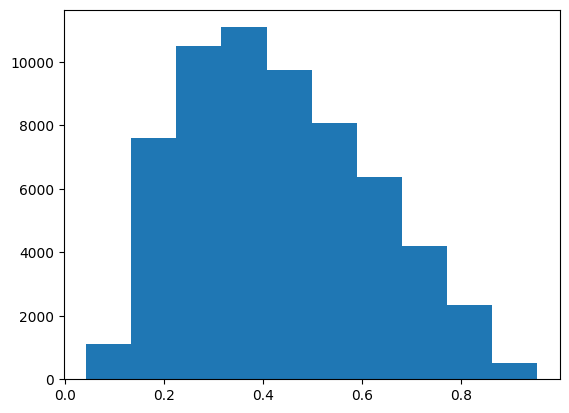

In [ ]:
y_proba_rfc=best_model_rfc_gs.predict_proba(X_test_norm)[:, 1]
y_pred_rfc=best_model_rfc_gs.predict(X_test_norm)
plt.hist(y_proba_rfc)

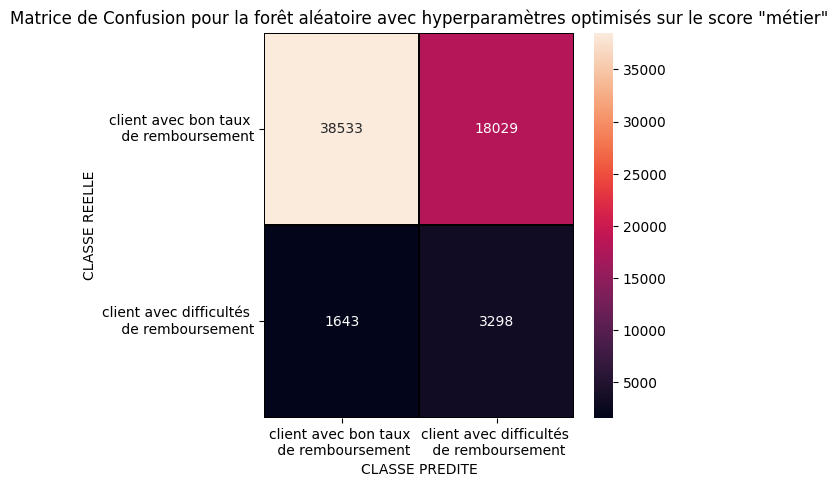

In [ ]:
# Graphique de la matrice de confusion
cm_rfc = confusion_matrix(y_test, y_pred_rfc)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_rfc, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la forêt aléatoire avec hyperparamètres optimisés sur le score "métier"')
plt.show()

In [ ]:
# score de la forêt aléatoire avec hyper-paramètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred_rfc)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_rfc)))
print('Recall Score : ' + str(recall_score(y_test, y_pred_rfc)))
print('F1 Score : ' + str(f1_score(y_test, y_pred_rfc)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test, y_pred_rfc, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test, y_proba_rfc)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_proba_rfc)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_pred_rfc)))

Accuracy Score : 0.6801456839503764
Precision Score : 0.15463965864866133
Recall Score : 0.6674762193887877
F1 Score : 0.2511040048728491
F beta Score (avec beta=3) : 0.5012462763693841
Aire sous la courbe ROC : 0.7347664858254814
Aire sous la courbe PR : 0.21357555948648044
Score de couts des erreurs de prédiction : 34459


Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser notre score "métier" créé sur les données d'entrainement non équilibrées.

In [ ]:
# probabilité des prédictiond sur les données d'entrainement avec les meilleurs hyperparamètres pour optimiser le seuil de décision
y_proba_rfc_train = best_model_rfc_gs.predict_proba(X_train_norm)[:, 1]
y_pred_rfc_train = best_model_rfc_gs.predict(X_train_norm)

Best Threshold : 0.55
Best Score : 80659


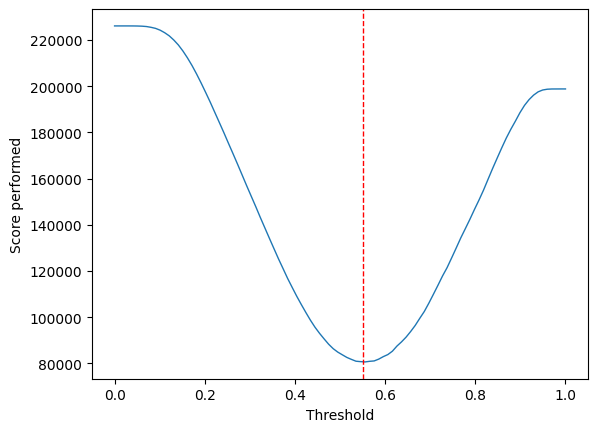

In [ ]:
threshold_selection_cout(y_proba_rfc_train,y_train)

Evaluons ces hyper-paramètres ainsi que ce seuil optimisé sur les données de test :

In [ ]:
# prédiction sur les données de test avec les meilleurs hyperparamètres et le seuil optimisé avec le score "métier"
y_rfc_opt_test = (best_model_rfc_gs.predict_proba(X_test_norm)[:,1] >= 0.55).astype(int)
y_rfc_opt_proba_test = best_model_rfc_gs.predict_proba(X_test_norm)[:, 1]

In [ ]:
# score de la forêt aléatoire avec hyperparamètres et seuil optimisés avec le score "métier"
print('Accuracy Score : ' + str(accuracy_score(y_test,y_rfc_opt_test)))
print('Precision Score : ' + str(precision_score(y_test,y_rfc_opt_test)))
print('Recall Score : ' + str(recall_score(y_test,y_rfc_opt_test)))
print('F1 Score : ' + str(f1_score(y_test,y_rfc_opt_test)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_rfc_opt_test, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_rfc_opt_test)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_rfc_opt_test)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_rfc_opt_test)))

Accuracy Score : 0.7426792188998911
Precision Score : 0.17341734173417342
Recall Score : 0.5849018417324429
F1 Score : 0.2675182819587152
F beta Score (avec beta=3) : 0.47273203127555863
Aire sous la courbe ROC : 0.670681888653782
Aire sous la courbe PR : 0.13478008933451127
Score de couts des erreurs de prédiction : 34285


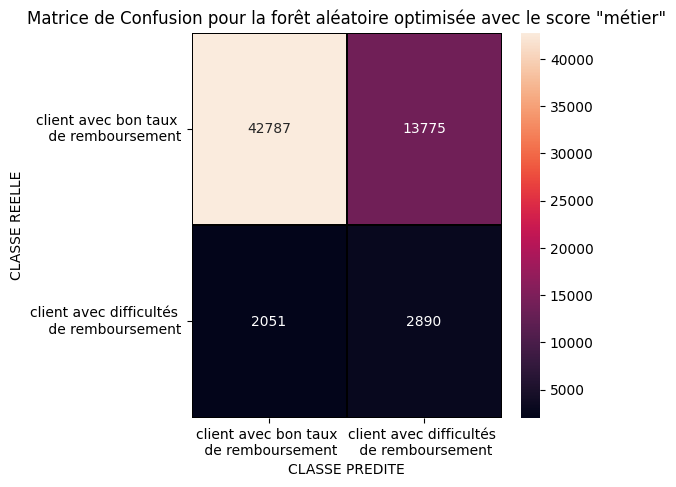

In [ ]:
# Graphique de la matrice de confusion
cm_rfc = confusion_matrix(y_test, y_rfc_opt_test)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_rfc, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour la forêt aléatoire optimisée avec le score "métier"')
plt.show()

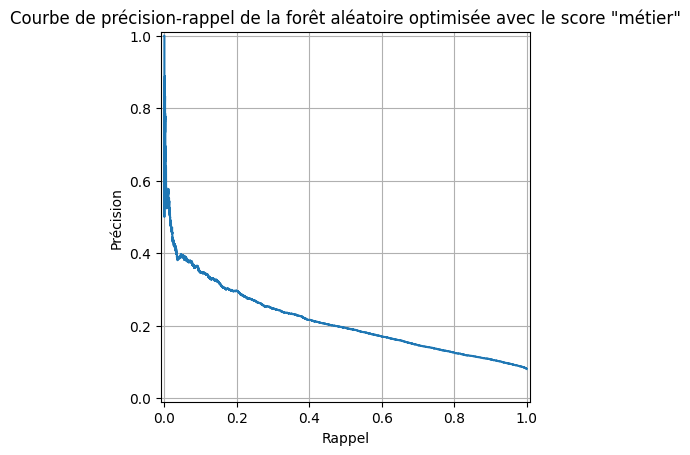

In [ ]:
# Graphique précision-rappel
precision_rfc, recall_rfc, _ = precision_recall_curve(y_test, y_rfc_opt_proba_test)
disp_neuron = PrecisionRecallDisplay(precision=precision_rfc, recall=recall_rfc)
disp_neuron.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel de la forêt aléatoire optimisée avec le score "métier"')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC de la forêt aléatoire optimisée avec le score "métier"')

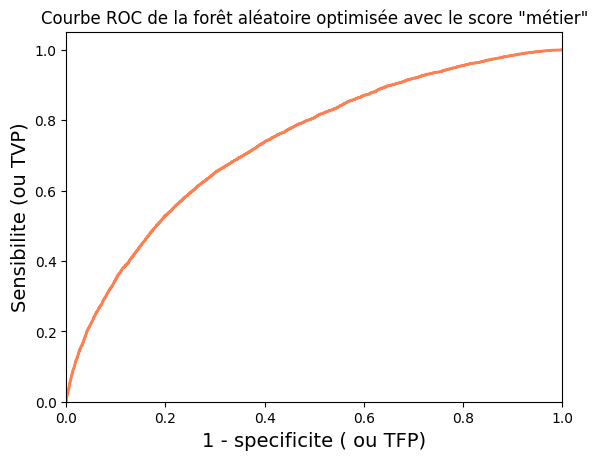

In [ ]:
# Graphique courbe ROC
[fpr_rfc, tpr_rfc, thr_rfc] = metrics.roc_curve(y_test, y_rfc_opt_proba_test)
plt.plot(fpr_rfc, tpr_rfc, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC de la forêt aléatoire optimisée avec le score "métier"')

Text(0.5, 0, "Top 20 des variables avec le plus d'importance")

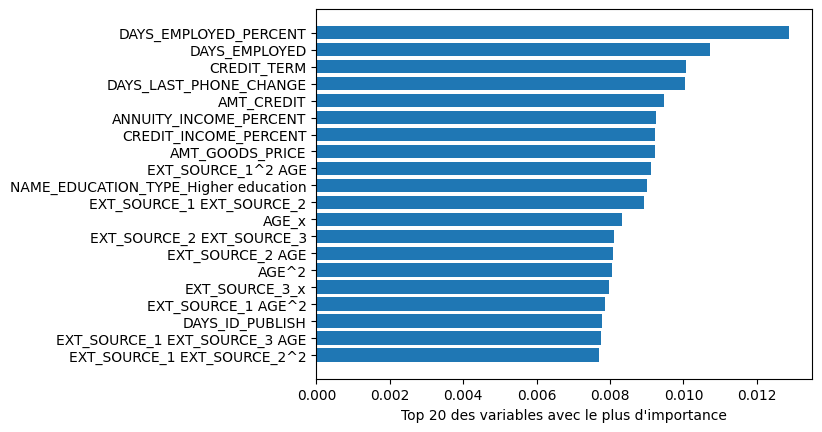

In [ ]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
perm_importance = permutation_importance(best_model_rfc_gs, X_train_eq,y_train_eq)

feature_names = X_train_eq.columns
features = np.array(feature_names)

sorted_idx = abs(perm_importance.importances_mean).argsort()
plt.barh(features[sorted_idx[-20:]], perm_importance.importances_mean[sorted_idx[-20:]])
plt.xlabel("Top 20 des variables avec le plus d'importance")


Nous pouvons voir que les variables "DAYS_EMPLOYED", "DAYS_EMPLOYED_PERCENT" et "CREDIT_TERM" ont une importance élevée dans ce modèle optimisé de forêt aléatoire.


In [ ]:
#  Sélection du seuil pour diminuer le nombre de variables si nombre de lignes peu important et risque d'overfitting

# from sklearn.feature_selection import SelectFromModel
# select = SelectFromModel(rfc.fit(X_train_eq,y_train_eq), prefit=True, threshold=0.01)
# X_train2 = select.transform(X_train_eq)
# print(X_train2.shape)

# avec boucle
# selectbislist=[]
# Xtrainbis=[]
# for i in [x / 1000.0 for x in range(5, 26, 5)]   :
#   selectbis=SelectFromModel(best_model_rfc_gs, prefit=True, threshold=i)
#   selectbislist.append(selectbis)
#   temp=selectbis.transform(X_train_eq)
#   Xtrainbis.append(temp)

### Modèles ensembliste séquentiel du XGBoost:

Le boosting va produire des modèles qui sont très dépendants les uns des autres, contrairement au principe du bagging. En effet les modèles sont entraînés itérativement comme suit :

- La première étape consiste à créer un premier modèle de base partir d'un algorithme choisi. Il est entraîné sur les données. Au début, on attribue des poids égaux à toutes les observations. À partir des résultats obtenus de ce modèle, si une observation est mal classée, cela augmente son poids.

- Ensuite, un second modèle est construit pour tenter de corriger les erreurs présentes dans le premier modèle. Il est entraîné à l'aide des données pondérées obtenues dans la première étape. Cette procédure se poursuit et des modèles sont ajoutés jusqu’à ce que l’ensemble complet des données de formation soit prédit correctement ou que le nombre maximal de modèles soit ajouté.

- Les prédictions du dernier modèle ajouté seront les prédictions globales pondérées fournies par les anciens modèles d’arbres.


In [ ]:
pipeline_bst=imbpipeline(steps=[
    ['classifier', XGBClassifier(objective='binary:logistic',random_state=42)]
])

params_bst = {"classifier__learning_rate" : [0.05,0.1,0.5],"classifier__max_depth": [None] + list(range(2, 10, 2)),"classifier__n_estimators" : [100,500,1000]}
scorer = {'main': 'accuracy', 'f1' : 'f1','custom': make_scorer(cout_score, greater_is_better=False)}

# optimisation des paramètres avec la grid search en fonction de notre score "métier"
grid_bst = GridSearchCV(pipeline_bst, params_bst,scoring=scorer,refit='custom', cv=3, n_jobs=None)
grid_bst.fit(X_train_eq,y_train_eq)

#récupération des meilleurs hyperparamètres
best_model_bst_gs = grid_bst.best_estimator_

In [ ]:
print(best_model_bst_gs)

Pipeline(steps=[['classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1

In [ ]:
cvres_bst=pd.DataFrame(grid_bst.cv_results_)
cvres_bst

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       12.309940      5.774341         0.129392        0.009464   
1       34.735128      6.875284         0.247301        0.001425   
2       62.183398      6.368886         0.402026        0.001522   
3        7.751072      5.720717         0.156179        0.038506   
4       11.184286      6.959041         0.127266        0.008218   
5       26.518797      0.473786         0.175892        0.007174   
6        7.591790      6.785376         0.101614        0.000302   
7       24.134212      0.214917         0.185718        0.010267   
8       36.823109      6.592846         0.303036        0.042761   
9       13.839566      6.572440         0.161193        0.060436   
10      34.883950      6.527706         0.247837        0.009349   
11      63.563014      6.087945         0.421866        0.006314   
12      17.555316      6.472497         0.128741        0.000948   
13      59.075805      3.680221         0.434874        0.172249   
14     105.867813      0.494270         0.576709        0.010056   
15       8.947980      6.718118         0.141418        0.027535   
16      34.179845      6.508527         0.243394        0.001801   
17      67.116983      6.797918         0.407948        0.009861   
18       1.949570      0.024945         0.107670        0.002944   
19      15.714951      4.684340         0.179278        0.062972   
20      26.128918      0.333011         0.174859        0.007251   
21       7.576751      6.942333         0.109275        0.003635   
22      18.467515      4.492188         0.237413        0.083663   
23      41.326594      7.046809         0.289489        0.004157   
24       8.996077      6.765234         0.117115        0.001952   
25      34.019421      5.730246         0.323975        0.106175   
26      62.175067      6.847268         0.413772        0.001850   
27      16.058281      3.409816         0.166667        0.033764   
28      57.093171      4.700504         0.459079        0.189075   
29      99.313172      3.056606         0.842175        0.351828   
30       8.661683      6.860809         0.117635        0.000643   
31      34.383373      6.476632         0.245970        0.004050   
32      66.972212      7.125876         0.412811        0.020370   
33       1.921326      0.005597         0.096840        0.004747   
34      15.742271      6.561601         0.161175        0.048960   
35      26.269516      0.153717         0.171765        0.004053   
36       7.250756      6.620248         0.141330        0.049710   
37      18.739923      6.960639         0.190486        0.010442   
38      41.992384      6.253136         0.285951        0.002164   
39       8.560105      6.884080         0.117241        0.001144   
40      34.205692      6.760422         0.239936        0.004293   
41      61.779921      4.951515         0.508418        0.137280   
42      15.392222      6.571499         0.169193        0.038193   
43      45.455526      6.389573         0.381207        0.096390   
44      83.310106      7.347022         0.681244        0.159576   

    param_classifier__learning_rate param_classifier__max_depth  \
0                              0.05                        None   
1                              0.05                        None   
2                              0.05                        None   
3                              0.05                           2   
4                              0.05                           2   
5                              0.05                           2   
6                              0.05                           4   
7                              0.05                           4   
8                              0.05                           4   
9                              0.05                           6   
10                             0.05                           6   
11                             0.05                           6   
12  

In [ ]:
cols= [i for i in cvres_bst.columns if "split" not in i ]
cvres_bst=cvres_bst [cols].sort_values("rank_test_main")
cvres_bst.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
7       24.134212      0.214917         0.185718        0.010267   
5       26.518797      0.473786         0.175892        0.007174   
20      26.128918      0.333011         0.174859        0.007251   
19      15.714951      4.684340         0.179278        0.062972   
8       36.823109      6.592846         0.303036        0.042761   
22      18.467515      4.492188         0.237413        0.083663   
24       8.996077      6.765234         0.117115        0.001952   
15       8.947980      6.718118         0.141418        0.027535   
33       1.921326      0.005597         0.096840        0.004747   
4       11.184286      6.959041         0.127266        0.008218   

    param_classifier__learning_rate param_classifier__max_depth  \
7                              0.05                           4   
5                              0.05                           2   
20                             0.10                           2   
19                             0.10                           2   
8                              0.05                           4   
22                             0.10                           4   
24                             0.10                           6   
15                             0.10                        None   
33                             0.50                           2   
4                              0.05                           2   

    param_classifier__n_estimators  \
7                              500   
5                             1000   
20                            1000   
19                             500   
8                             1000   
22                             500   
24                             100   
15                             100   
33                             100   
4                              500   

                                               params  mean_test_main  \
7   {'classifier__learning_rate': 0.05, 'classifie...        0.693849   
5   {'classifier__learning_rate': 0.05, 'classifie...        0.693472   
20  {'classifier__learning_rate': 0.1, 'classifier...        0.692869   
19  {'classifier__learning_rate': 0.1, 'classifier...        0.692768   
8   {'classifier__learning_rate': 0.05, 'classifie...        0.692064   
22  {'classifier__learning_rate': 0.1, 'classifier...        0.691913   
24  {'classifier__learning_rate': 0.1, 'classifier...        0.691762   
15  {'classifier__learning_rate': 0.1, 'classifier...        0.691762   
33  {'classifier__learning_rate': 0.5, 'classifier...        0.691636   
4   {'classifier__learning_rate': 0.05, 'classifie...        0.690882   

    std_test_main  rank_test_main  mean_test_f1  std_test_f1  rank_test_f1  \
7        0.003015               1      0.693338     0.002359             2   
5        0.003492               2      0.693402     0.002728             1   
20       0.003857               3      0.692382     0.002944             4   
19       0.003705               4      0.692836     0.003065             3   
8        0.003409               5      0.691790     0.002860             7   
22       0.002042               6      0.692025     0.001133             6   
24       0.002815               7      0.691247     0.002976             8   
15       0.002815               7      0.691247     0.002976             8   
33       0.003724               9      0.692172     0.003577             5   
4        0.003068              10      0.691098     0.002170            10   

    mean_test_custom  std_test_custom  rank_test_custom  
7      -22421.333333        91.288310                 4  
5      -22363.333333       106.962091                 1  
20     -22488.333333       114.374628                 6  
19     -22387.666667       145.181113                 3  
8      -22505.000000       143.338760                 8  
22     -22441.000000        30.210373                 5  
24     -22572.000000       27

In [ ]:
cols= [i for i in cvres_bst.columns if "split" not in i ]
cvres_bst=cvres_bst [cols].sort_values("rank_test_f1")
cvres_bst.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       26.518797      0.473786         0.175892        0.007174   
7       24.134212      0.214917         0.185718        0.010267   
19      15.714951      4.684340         0.179278        0.062972   
20      26.128918      0.333011         0.174859        0.007251   
33       1.921326      0.005597         0.096840        0.004747   
22      18.467515      4.492188         0.237413        0.083663   
8       36.823109      6.592846         0.303036        0.042761   
24       8.996077      6.765234         0.117115        0.001952   
15       8.947980      6.718118         0.141418        0.027535   
4       11.184286      6.959041         0.127266        0.008218   

    param_classifier__learning_rate param_classifier__max_depth  \
5                              0.05                           2   
7                              0.05                           4   
19                             0.10                           2   
20                             0.10                           2   
33                             0.50                           2   
22                             0.10                           4   
8                              0.05                           4   
24                             0.10                           6   
15                             0.10                        None   
4                              0.05                           2   

    param_classifier__n_estimators  \
5                             1000   
7                              500   
19                             500   
20                            1000   
33                             100   
22                             500   
8                             1000   
24                             100   
15                             100   
4                              500   

                                               params  mean_test_main  \
5   {'classifier__learning_rate': 0.05, 'classifie...        0.693472   
7   {'classifier__learning_rate': 0.05, 'classifie...        0.693849   
19  {'classifier__learning_rate': 0.1, 'classifier...        0.692768   
20  {'classifier__learning_rate': 0.1, 'classifier...        0.692869   
33  {'classifier__learning_rate': 0.5, 'classifier...        0.691636   
22  {'classifier__learning_rate': 0.1, 'classifier...        0.691913   
8   {'classifier__learning_rate': 0.05, 'classifie...        0.692064   
24  {'classifier__learning_rate': 0.1, 'classifier...        0.691762   
15  {'classifier__learning_rate': 0.1, 'classifier...        0.691762   
4   {'classifier__learning_rate': 0.05, 'classifie...        0.690882   

    std_test_main  rank_test_main  mean_test_f1  std_test_f1  rank_test_f1  \
5        0.003492               2      0.693402     0.002728             1   
7        0.003015               1      0.693338     0.002359             2   
19       0.003705               4      0.692836     0.003065             3   
20       0.003857               3      0.692382     0.002944             4   
33       0.003724               9      0.692172     0.003577             5   
22       0.002042               6      0.692025     0.001133             6   
8        0.003409               5      0.691790     0.002860             7   
24       0.002815               7      0.691247     0.002976             8   
15       0.002815               7      0.691247     0.002976             8   
4        0.003068              10      0.691098     0.002170            10   

    mean_test_custom  std_test_custom  rank_test_custom  
5      -22363.333333       106.962091                 1  
7      -22421.333333        91.288310                 4  
19     -22387.666667       145.181113                 3  
20     -22488.333333       114.374628                 6  
33     -22378.666667       248.518723                 2  
22     -22441.000000        30.210373                 5  
8      -22505.000000       14

In [ ]:
cols= [i for i in cvres_bst.columns if "split" not in i ]
cvres_bst=cvres_bst [cols].sort_values("rank_test_custom")
cvres_bst.head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
5       26.518797      0.473786         0.175892        0.007174   
33       1.921326      0.005597         0.096840        0.004747   
19      15.714951      4.684340         0.179278        0.062972   
7       24.134212      0.214917         0.185718        0.010267   
22      18.467515      4.492188         0.237413        0.083663   
20      26.128918      0.333011         0.174859        0.007251   
4       11.184286      6.959041         0.127266        0.008218   
8       36.823109      6.592846         0.303036        0.042761   
24       8.996077      6.765234         0.117115        0.001952   
15       8.947980      6.718118         0.141418        0.027535   

    param_classifier__learning_rate param_classifier__max_depth  \
5                              0.05                           2   
33                             0.50                           2   
19                             0.10                           2   
7                              0.05                           4   
22                             0.10                           4   
20                             0.10                           2   
4                              0.05                           2   
8                              0.05                           4   
24                             0.10                           6   
15                             0.10                        None   

    param_classifier__n_estimators  \
5                             1000   
33                             100   
19                             500   
7                              500   
22                             500   
20                            1000   
4                              500   
8                             1000   
24                             100   
15                             100   

                                               params  mean_test_main  \
5   {'classifier__learning_rate': 0.05, 'classifie...        0.693472   
33  {'classifier__learning_rate': 0.5, 'classifier...        0.691636   
19  {'classifier__learning_rate': 0.1, 'classifier...        0.692768   
7   {'classifier__learning_rate': 0.05, 'classifie...        0.693849   
22  {'classifier__learning_rate': 0.1, 'classifier...        0.691913   
20  {'classifier__learning_rate': 0.1, 'classifier...        0.692869   
4   {'classifier__learning_rate': 0.05, 'classifie...        0.690882   
8   {'classifier__learning_rate': 0.05, 'classifie...        0.692064   
24  {'classifier__learning_rate': 0.1, 'classifier...        0.691762   
15  {'classifier__learning_rate': 0.1, 'classifier...        0.691762   

    std_test_main  rank_test_main  mean_test_f1  std_test_f1  rank_test_f1  \
5        0.003492               2      0.693402     0.002728             1   
33       0.003724               9      0.692172     0.003577             5   
19       0.003705               4      0.692836     0.003065             3   
7        0.003015               1      0.693338     0.002359             2   
22       0.002042               6      0.692025     0.001133             6   
20       0.003857               3      0.692382     0.002944             4   
4        0.003068              10      0.691098     0.002170            10   
8        0.003409               5      0.691790     0.002860             7   
24       0.002815               7      0.691247     0.002976             8   
15       0.002815               7      0.691247     0.002976             8   

    mean_test_custom  std_test_custom  rank_test_custom  
5      -22363.333333       106.962091                 1  
33     -22378.666667       248.518723                 2  
19     -22387.666667       145.181113                 3  
7      -22421.333333        91.288310                 4  
22     -22441.000000        30.210373                 5  
20     -22488.333333       114.374628                 6  
4      -22496.666667        5

Les hyperparamètres optimisés correspondent à la combinaison {'max depth':2 , 'learning rate': 0.05, 'n estimators' : 1000} et entrainent une maximisation  du mean_test_custom (= -1*cout_score) égal à -22363.33 avec un temps d'entrainement et de prédiction correct.


Evaluons ces hyper-paramètres sur le jeu de test :

In [ ]:
best_model_bst_gs.fit(X_train_eq,y_train_eq)

Pipeline(steps=[['classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...)]])

(array([ 2449.,  8599., 10401., 10001.,  8758.,  7585.,  6108.,  4542.,
         2473.,   587.]),
 array([0.01666363, 0.11200079, 0.20733796, 0.30267513, 0.39801228,
        0.49334943, 0.58868659, 0.6840238 , 0.77936095, 0.8746981 ,
        0.97003525]),
 <BarContainer object of 10 artists>)

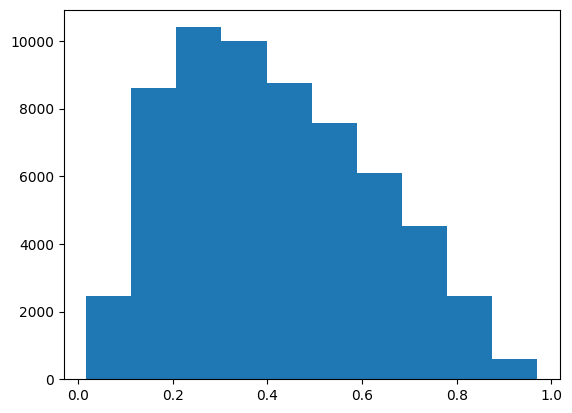

In [ ]:
y_proba_bst=best_model_bst_gs.predict_proba(X_test_norm)[:, 1]
y_pred_bst=best_model_bst_gs.predict(X_test_norm)
plt.hist(y_proba_bst)

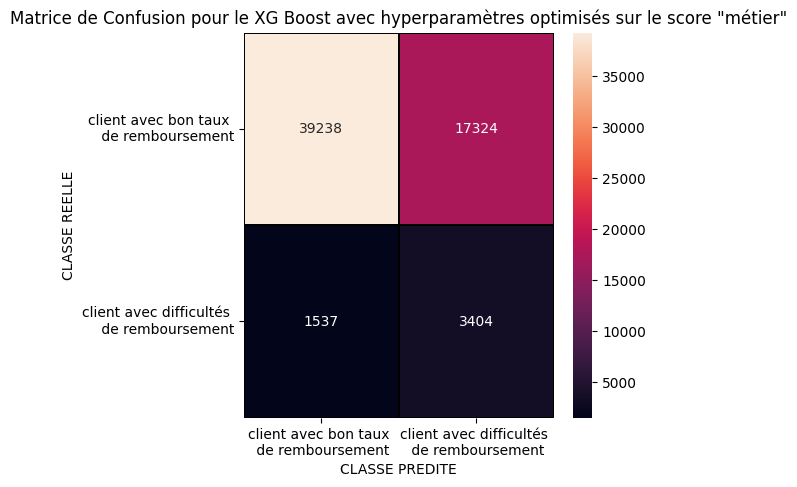

In [ ]:
# Graphique de la matrice de confusion
cm_bst = confusion_matrix(y_test, y_pred_bst)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_bst, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le XG Boost avec hyperparamètres optimisés sur le score "métier"')
plt.show()

In [ ]:
# score du XG Boost avec hyper-paramètres optimisés
print('Accuracy Score : ' + str(accuracy_score(y_test, y_pred_bst)))
print('Precision Score : ' + str(precision_score(y_test, y_pred_bst)))
print('Recall Score : ' + str(recall_score(y_test, y_pred_bst)))
print('F1 Score : ' + str(f1_score(y_test, y_pred_bst)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test, y_pred_bst, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test, y_proba_bst)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_proba_bst)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_pred_bst)))

Accuracy Score : 0.6933320325837764
Precision Score : 0.16422230798919335
Recall Score : 0.6889293665249949
F1 Score : 0.26522264209747165
F beta Score (avec beta=3) : 0.5221099130328083
Aire sous la courbe ROC : 0.7614152236659903
Aire sous la courbe PR : 0.24215388325631054
Score de couts des erreurs de prédiction : 32694


Maintenant, cherchons à optimiser le seuil de décision de l'algorithme en cherchant à minimiser notre score "métier" créé sur les données d'entrainement non équilibrées.

In [ ]:
# probabilité des prédictiond sur les données d'entrainement avec les meilleurs hyperparamètres pour optimiser le seuil de décision
y_proba_bst_train = best_model_bst_gs.predict_proba(X_train_norm)[:, 1]
y_pred_bst_train = best_model_bst_gs.predict(X_train_norm)

Best Threshold : 0.52
Best Score : 125523


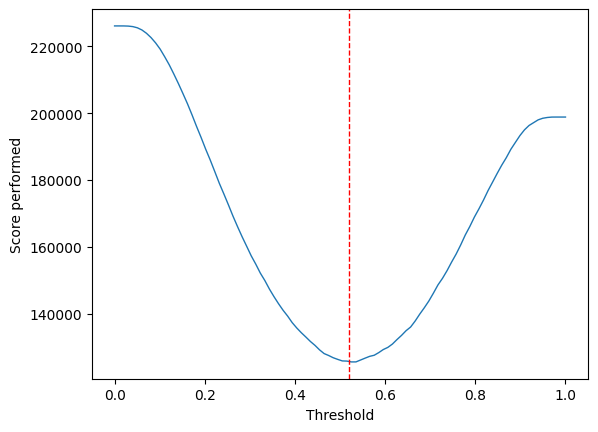

In [ ]:
threshold_selection_cout(y_proba_bst_train,y_train)

Evaluons ces hyper-paramètres ainsi que ce seuil optimisé sur les données de test :

In [11]:
# prédiction sur les données de test avec les meilleurs hyperparamètres et le seuil optimisé avec le score "métier"
y_bst_opt_test = (best_model_bst_gs.predict_proba(X_test_norm)[:,1] >= 0.52).astype(int)
y_bst_opt_proba_test = best_model_bst_gs.predict_proba(X_test_norm)[:, 1]

In [ ]:
# score du XG Boost avec hyperparamètres et seuil optimisés avec le score "métier"
print('Accuracy Score : ' + str(accuracy_score(y_test,y_bst_opt_test)))
print('Precision Score : ' + str(precision_score(y_test,y_bst_opt_test)))
print('Recall Score : ' + str(recall_score(y_test,y_bst_opt_test)))
print('F1 Score : ' + str(f1_score(y_test,y_bst_opt_test)))
print('F beta Score (avec beta=3) : ' + str(fbeta_score(y_test,y_bst_opt_test, beta=3)))
print('Aire sous la courbe ROC : ' +str(roc_auc_score(y_test,y_bst_opt_test)))
print('Aire sous la courbe PR : ' +str(average_precision_score(y_test, y_bst_opt_test)))
print('Score de couts des erreurs de prédiction : ' +str(cout_score(y_test, y_bst_opt_test)))

Accuracy Score : 0.7169731557810188
Precision Score : 0.17163628700874511
Recall Score : 0.6593806921675774
F1 Score : 0.27237386615391046
F beta Score (avec beta=3) : 0.5134670848371184
Aire sous la courbe ROC : 0.6906924322900757
Aire sous la courbe PR : 0.1405381725328601
Score de couts des erreurs de prédiction : 32554


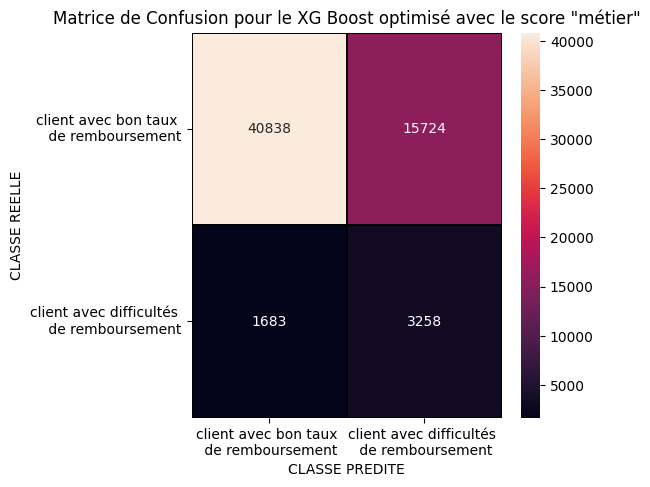

In [ ]:
# Graphique de la matrice de confusion
cm_bst = confusion_matrix(y_test, y_bst_opt_test)

x_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
y_axis_labels = ["client avec bon taux \n de remboursement", "client avec difficultés \n de remboursement"]
f, ax = plt.subplots(figsize =(5,5))
sns.heatmap(cm_bst, annot=True, linewidths=0.2, linecolor="black",
                fmt=".0f", ax=ax,
                xticklabels=x_axis_labels,
                yticklabels=y_axis_labels)
plt.yticks(rotation=0)
plt.ylabel("CLASSE REELLE")
plt.xlabel("CLASSE PREDITE")
plt.title('Matrice de Confusion pour le XG Boost optimisé avec le score "métier"')
plt.show()

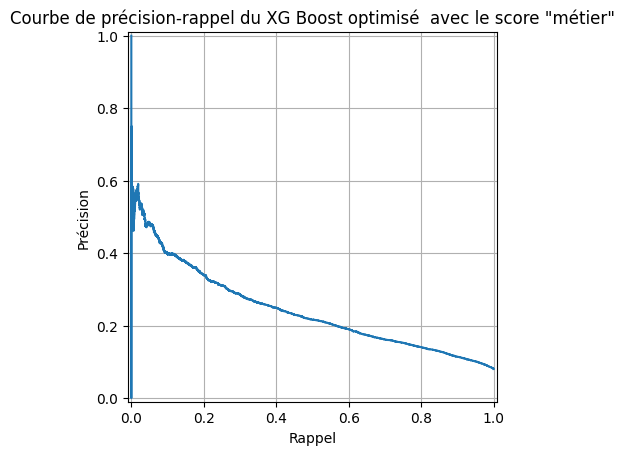

In [12]:
# Graphique précision-rappel
precision_bst, recall_bst, _ = precision_recall_curve(y_test, y_bst_opt_proba_test)
disp_neuron = PrecisionRecallDisplay(precision=precision_bst, recall=recall_bst)
disp_neuron.plot()
plt.xlabel('Rappel')
plt.ylabel('Précision')
plt.title('Courbe de précision-rappel du XG Boost optimisé  avec le score "métier"')
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Courbe ROC du XG Boost optimisé avec le score "métier"')

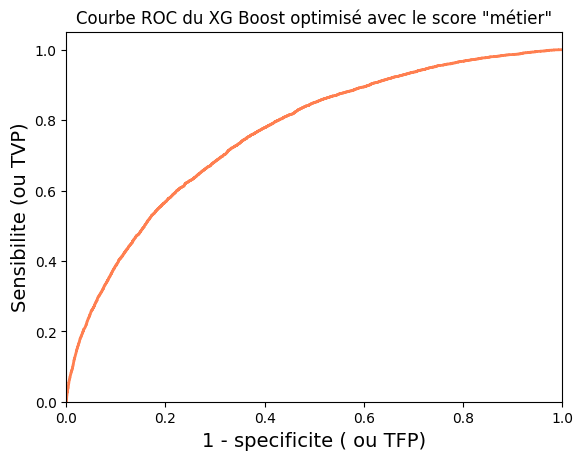

In [ ]:
# Graphique courbe ROC
[fpr_bst, tpr_bst, thr_bst] = metrics.roc_curve(y_test, y_bst_opt_proba_test)
plt.plot(fpr_bst, tpr_bst, color='coral', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - specificite ( ou TFP)', fontsize=14)
plt.ylabel('Sensibilite (ou TVP)', fontsize=14)
plt.title('Courbe ROC du XG Boost optimisé avec le score "métier"')

Text(0.5, 0, "Top 20 des variables avec le plus d'importance")

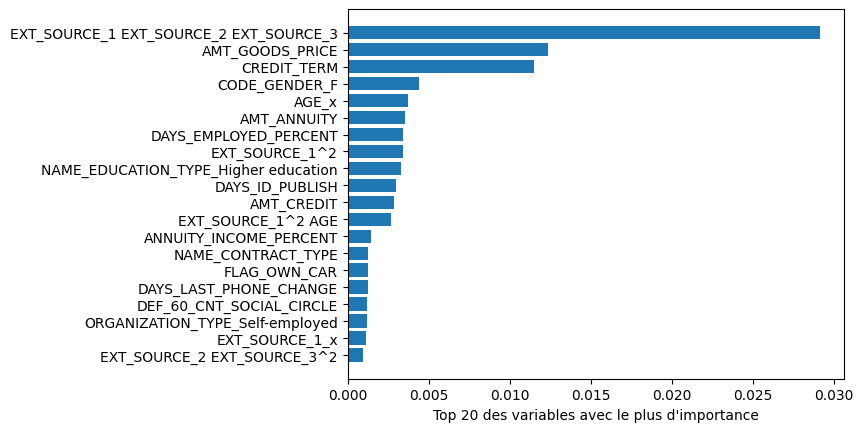

In [ ]:
# Graphique des 20 variables qui ont le plus d'importance pour ce modèle optimisé
perm_importance = permutation_importance(best_model_bst_gs, X_train_eq,y_train_eq)

feature_names = X_train_eq.columns
features = np.array(feature_names)

sorted_idx = abs(perm_importance.importances_mean).argsort()
plt.barh(features[sorted_idx[-20:]], perm_importance.importances_mean[sorted_idx[-20:]])
plt.xlabel("Top 20 des variables avec le plus d'importance")

Nous pouvons voir que la combinaison créée avec les 3 données EXT_SOURCE a l'importance la plus élevée dans ce modèle optimisé de XGBoost. Les variables 'CREDIT_TERM","AMT_GOODS_PRICE","CODE_GENDER_F" et "AGE" ont également un certain poids dans ce modèle.


### Choix du modèle :

Puisque notre but est de minimiser notre score "métier", l'algorithme du XG Boost semble le mieux adapté avec un score "métier" de 32554.

Cependant, ses temps d'entrainement et de prédiction sont plus importants.

Privilégions tout de même la performance et donc l'algorithme du XG Boost dans ce premier temps.

## Explication du modèle :

Observons maintenant comment les variables les plus importantes influencent les prédictions avec la fonction SHAP.

In [ ]:
model=XGBClassifier(objective='binary:logistic',learning_rate = 0.05,max_depth = 2,n_estimators = 1000,random_state=42)
model.fit(X_train_eq,y_train_eq)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_norm)

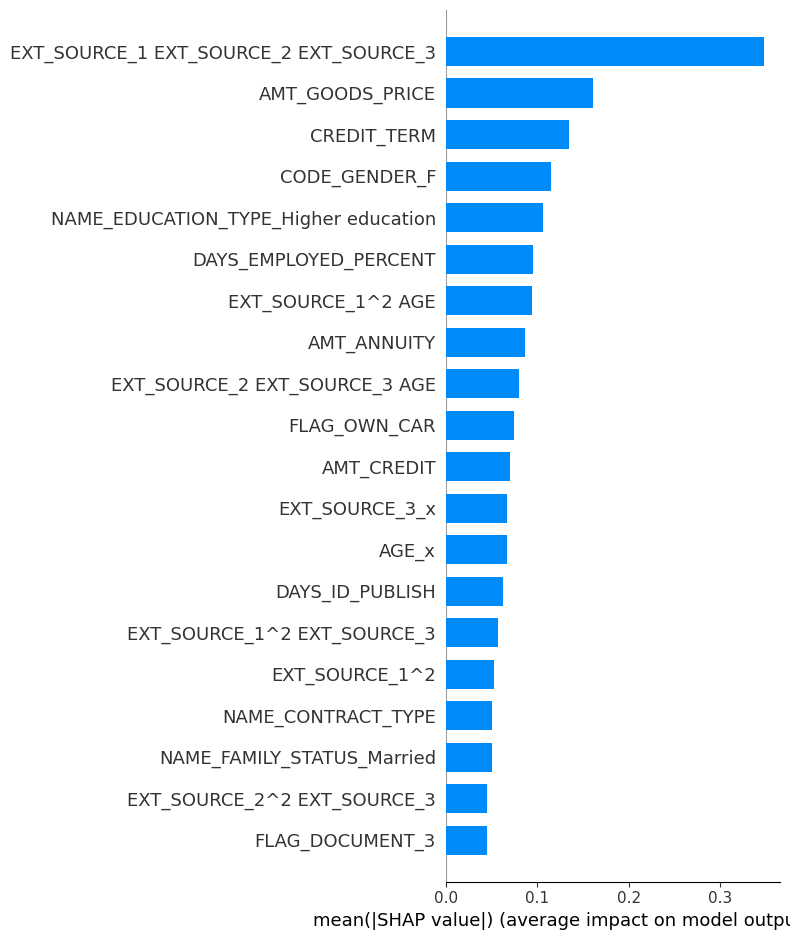

In [ ]:
shap.summary_plot(
    shap_values, X_test_norm, feature_names=X_test_norm.columns, plot_type="bar"
)

On trouve quelques différences avec la fonction feature_importance mais on retrouve la combinaison "EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3" qui prédomine.

D'autres variables comme "AMT_GOODS_PRICE" et "CREDIT TERM" sont les plus influentes.On les retrouve dans le top 20 du modèle de XG Boost.

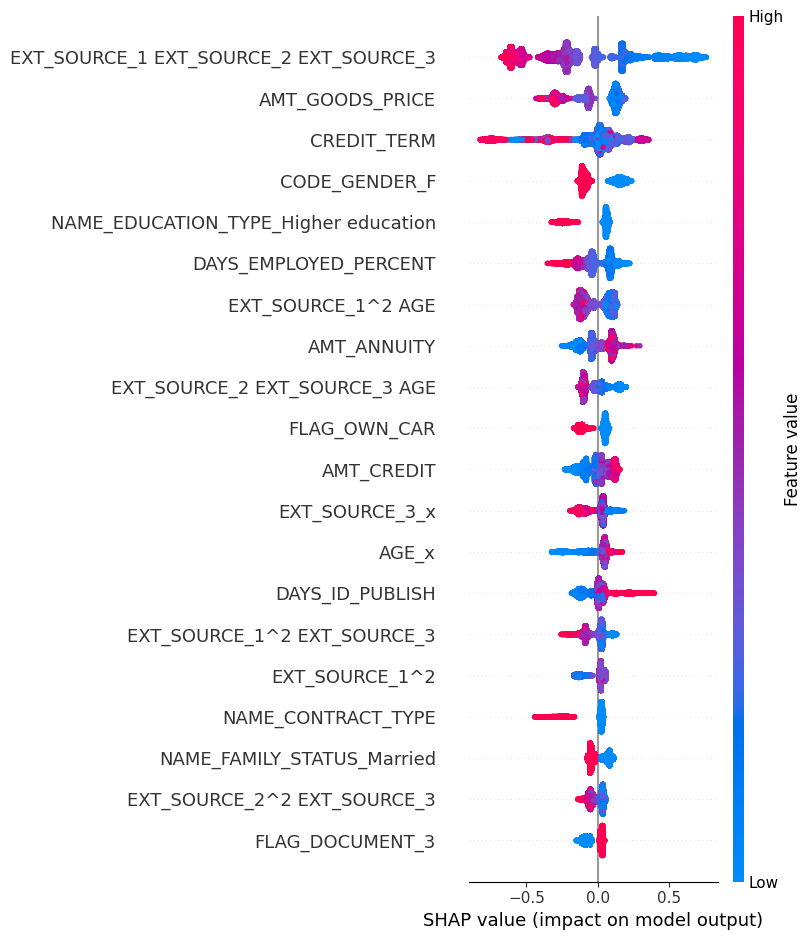

In [ ]:
shap.summary_plot(shap_values, X_test_norm)

Avec ce nouveau graphique, on peut voir que la combinaison "EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3" a essentiellement une influence négative sur le modèle quand ces valeurs sont hautes, de même pour "CREDIT_TERM" et "AMT_GOODS_PRICE". Cela signifie que, lorsque ces variables prennent des valeurs élevées dans une prédiction, il y a de fortes chances que le résultat de la classification soit 0 (classe avec bon taux de remboursement).

Nous pouvons également remarque que le genre féminin a, lui, une influence négative sur le modèle.

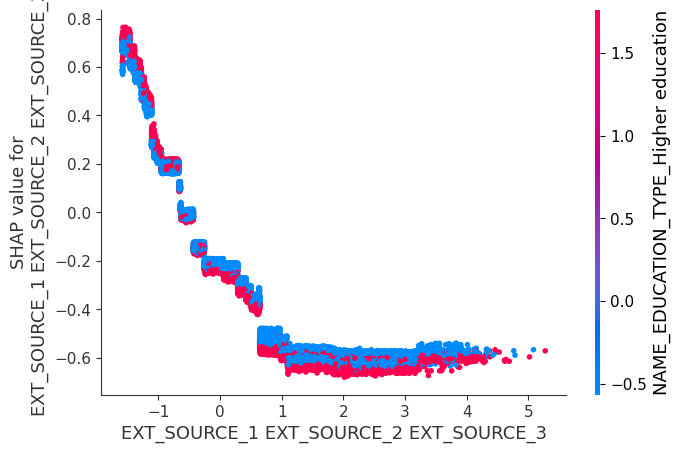

In [ ]:
shap.dependence_plot("EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3", shap_values, X_test_norm, interaction_index="auto")

On retrouve le fait que lorsque la valeur de la combinaison "EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3" augmente, la valeur de SHAP de cette combinaison diminue.

Apparemment, la combinaison "EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3" interagit plus avec la variable "NAME_EDUCATION_TYPE_Higher education" qu'avec les autres variables. Cependant, aucune corrélation ne semble pouvoir être déterminée visuellement entre ces deux variables.

### Local :

In [ ]:
shap_explainer_values = explainer(X_test_norm, y_test)


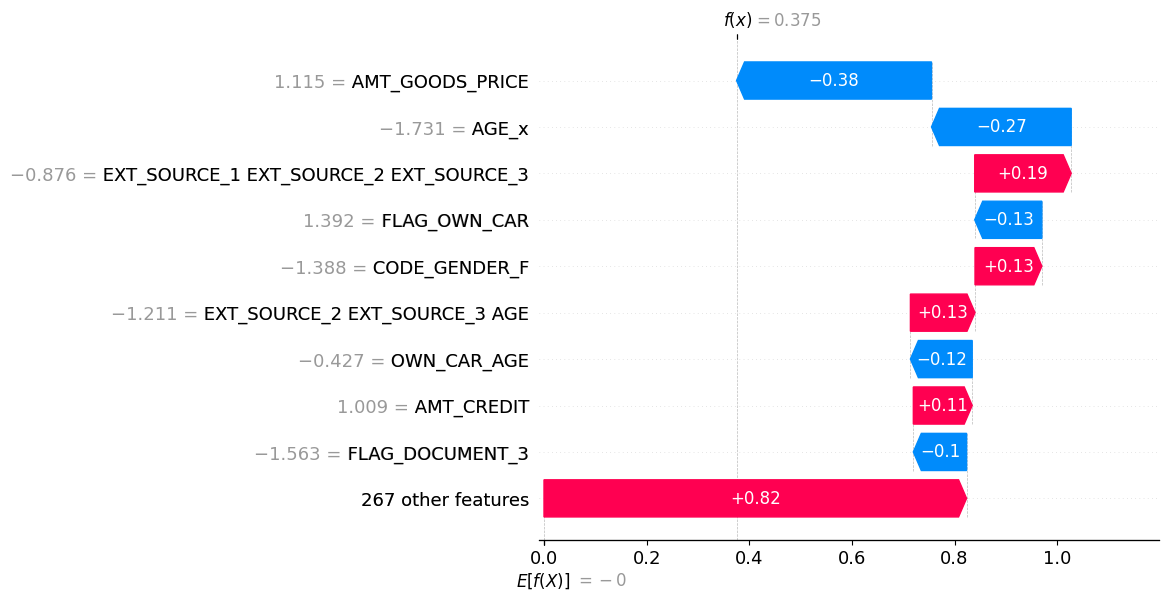

In [ ]:
#  Choix d'un individu aléatoire pour l'explication locale
random_idx = np.random.randint(len(X_test_norm))
shap.waterfall_plot(shap_explainer_values[random_idx])

Pour ce premier individu, on peut voir que la prédiction finale est plus fortement influencée positivement par "les autres variables" (+0,82) ainsi que par la combinaison "EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3" (+0,19) qui a une valeur négative de -0,876  qui a donc une influences positive comme vu dans l'explication globale au dessus.

Les influences négatives les plus importantes viennent de la variable "AMT_GOODS_PRICE" (-0,38)  qui a une valeur positive de 1,115 et la variable "AGE" qui a une valeur négative de -1,731 donc des influences négatives comme montré dans l'explication globale.

Le fait que l'individu soit un homme ("CODE_GENDER_F" négatif) influence également de façon positive la variable comme montré dans l'explication globale au dessus.

La prédiction finale est positive (0,375) et tend à classifier cet individu dans la classe 1 des individus avec des difficultés de remboursement.


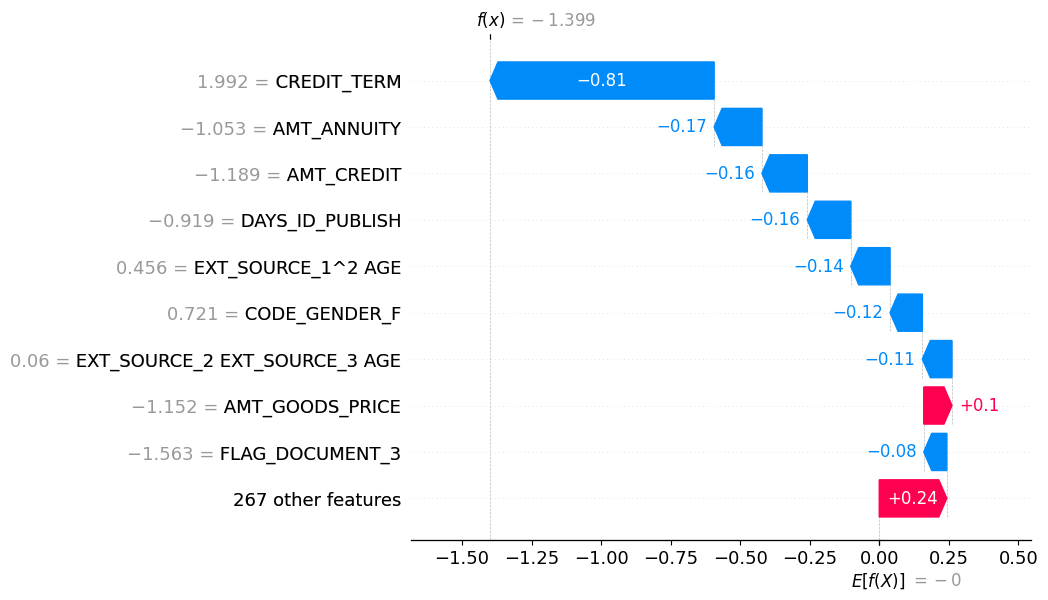

In [ ]:
#  Choix d'un individu aléatoire pour l'explication locale
random_idx = np.random.randint(len(X_test_norm))
shap.waterfall_plot(shap_explainer_values[random_idx])

Pour ce deuxième individu, on peut voir que la prédiction finale est plus fortement influencée négativement par la variable "CREDIT_TERM" (-0,81) qui a une valeur positive de 1,992 ainsi que par  la variable "AMT_ANNUITY" (-0,17) qui a une valeur négative de -1,053 (elles ont donc une influence négative comme montrée dans l'explication globale au dessus).

Le fait que l'individu soit une femme ("CODE_GENDER_F" positif) influence également de façon négative la variable comme montré dans l'explication globale au dessus.

La prédiction finale est négative (-1,399) et tend à classifier cet individu dans la classe 0 des individus qui ont un bon taux de remboursement.


#### Limitations

Le fait que les variables "EXT_SOURCE" soient des scores normalisés dont on ne connait pas vraiment ni la source ni le contenu, ne permet pas d'aller plus loin en terme d'explicabilité "métier" du modèle.

**Ressources :**


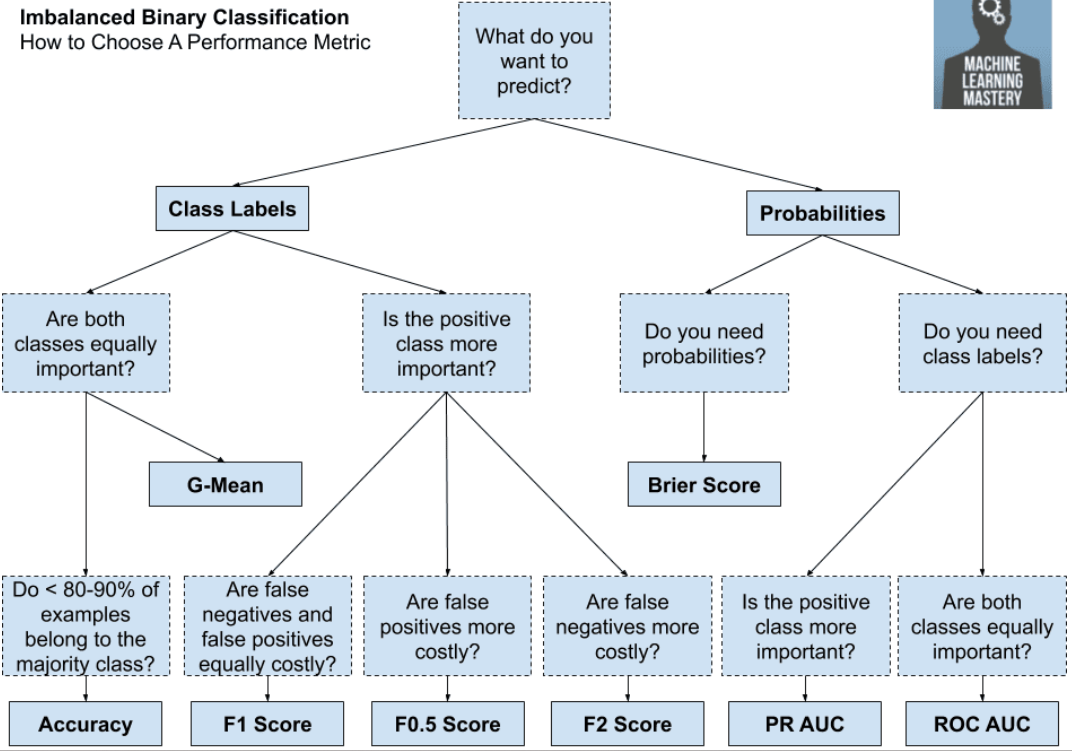